<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=146831317" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [ ]:
# source
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install plotly
!pip install yfinance
!pip install schedule
!pip install pykalman
!pip install pandas_ta
from IPython.display import clear_output
import plotly.graph_objects as go
import schedule,warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_13 = df.ta.ema(13, append=True)[-1:].reset_index(drop=True)[0]
    ema_31 = df.ta.ema(31, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_13 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_13'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_13'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_31'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_31 '))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# [Fear & Greed Index](https://www.cnn.com/markets/fear-and-greed)

In [ ]:
!pip install fear-and-greed
clear_output()

import fear_and_greed
#type(fear_and_greed.get())

print('\nIndex: ',fear_and_greed.get()[0])
print('Range: ',fear_and_greed.get()[1])
print('Datetime: ',fear_and_greed.get()[2])

# Today's Yahoo Gainers 
## Including Recommendations, Candlesticks, Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, Exponential Moving Averages (EMA) & Kalman Forecast Predictors. 
### This notebook only plots entry & exit stocks out of the 100 from Yahoo's Gainers webpage.

In [ ]:
from datetime import datetime
today = pd.Timestamp(datetime.now(), tz='EST').strftime("%Y-%m-%d")
print(f"Calculating indicators for today's date: {today}.")

# Entry Points

Entry Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: MLTX

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 62.5

Ichimoku 9-Day Forecast: 56.540000915527344

Ichimoku 26-Day Forecast: 56.09550094604492

Choppiness (%): 53.21

RSI: 60.19084079129161

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

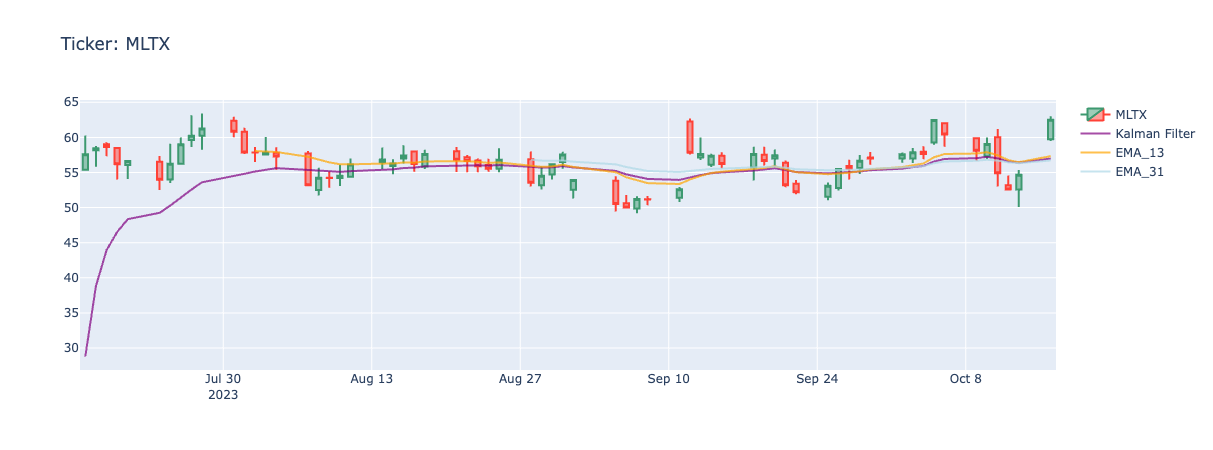

Ticker: LULU

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 414.73028564453125

Ichimoku 9-Day Forecast: 386.06500244140625

Ichimoku 26-Day Forecast: 386.06500244140625

Choppiness (%): 35.95

RSI: 70.14161117667888

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

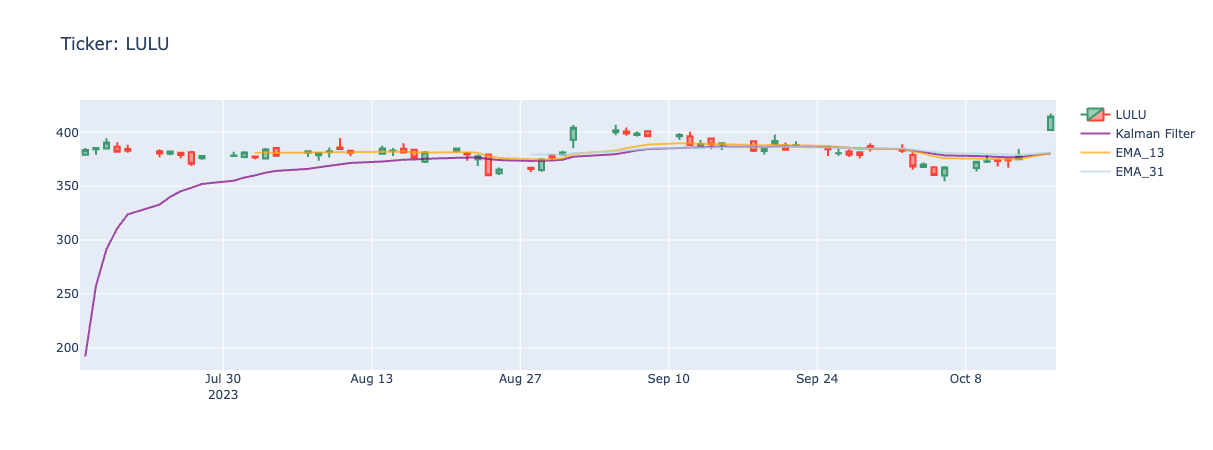

Ticker: ARZTF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 1.9700000286102295

Ichimoku 9-Day Forecast: 1.7300000190734863

Ichimoku 26-Day Forecast: 1.7300000190734863

Choppiness (%): 0.00

RSI: 97.17410375201085

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

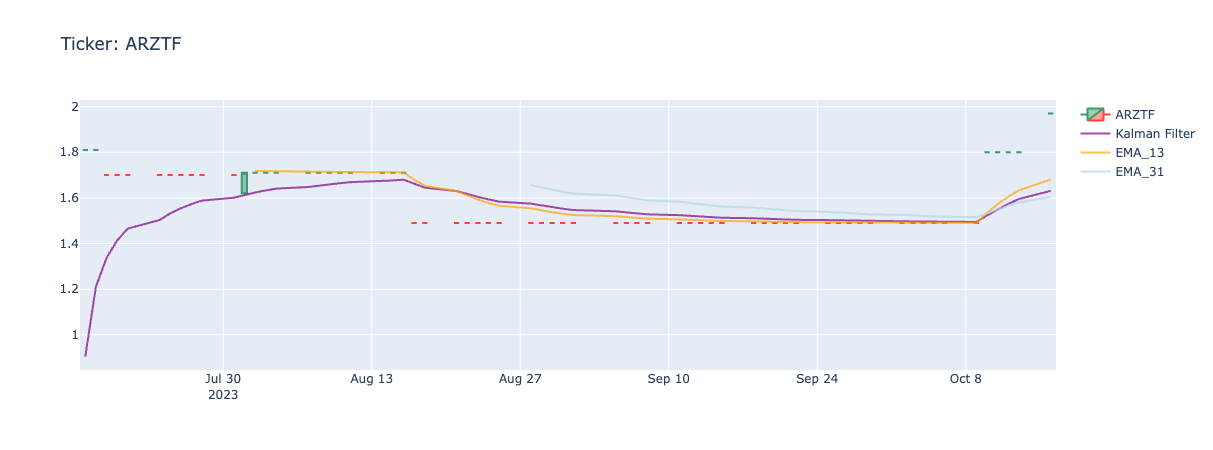

Ticker: BACHF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 0.36959999799728394

Ichimoku 9-Day Forecast: 0.35500000417232513

Ichimoku 26-Day Forecast: 0.3449999988079071

Choppiness (%): 49.09

RSI: 62.45432445325065

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

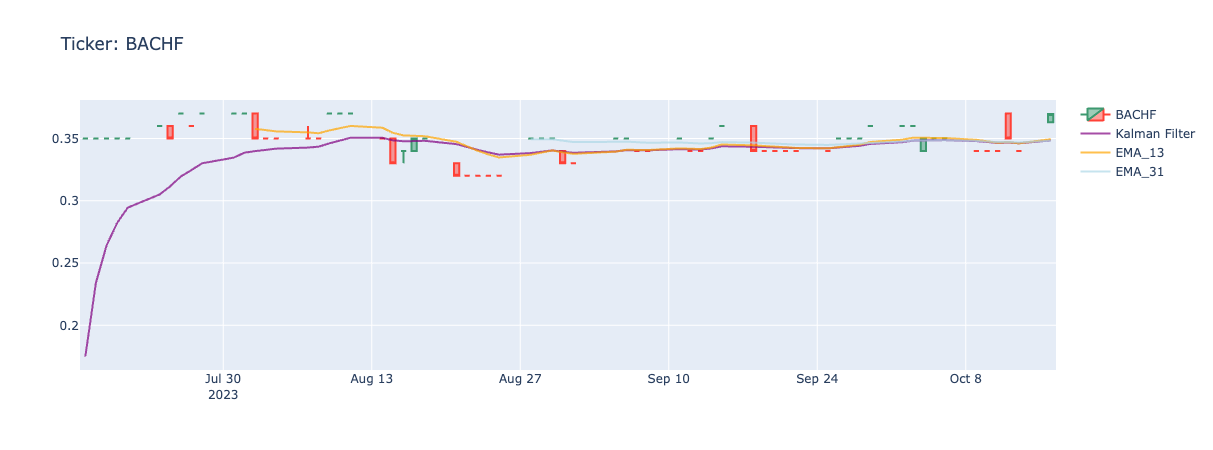

Ticker: SYM

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 42.149898529052734

Ichimoku 9-Day Forecast: 36.53499937057495

Ichimoku 26-Day Forecast: 45.99499988555908

Choppiness (%): 40.56

RSI: 64.06535563954074

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

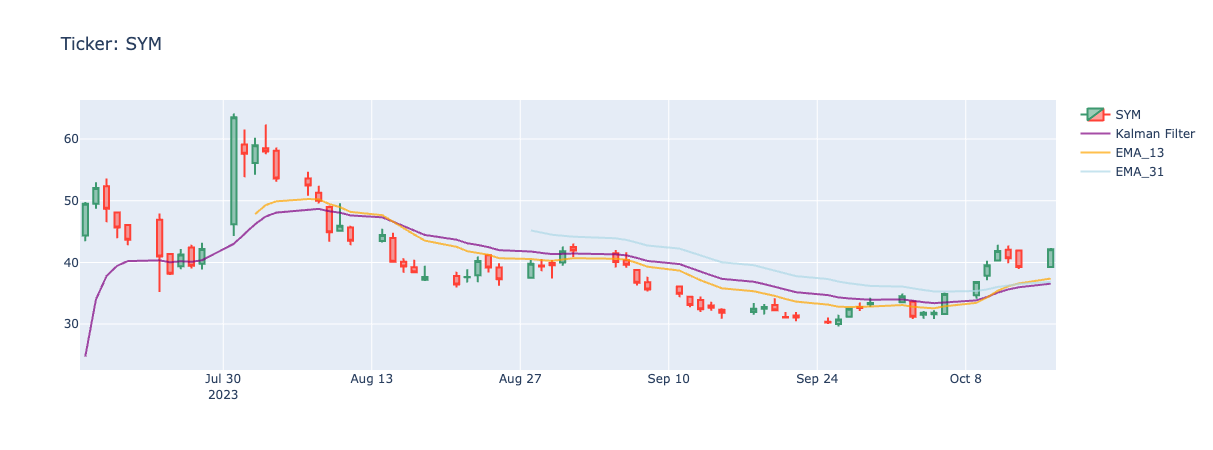

Ticker: TAL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 9.509900093078613

Ichimoku 9-Day Forecast: 8.822500109672546

Ichimoku 26-Day Forecast: 8.130000114440918

Choppiness (%): 53.04

RSI: 65.55501640313284

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

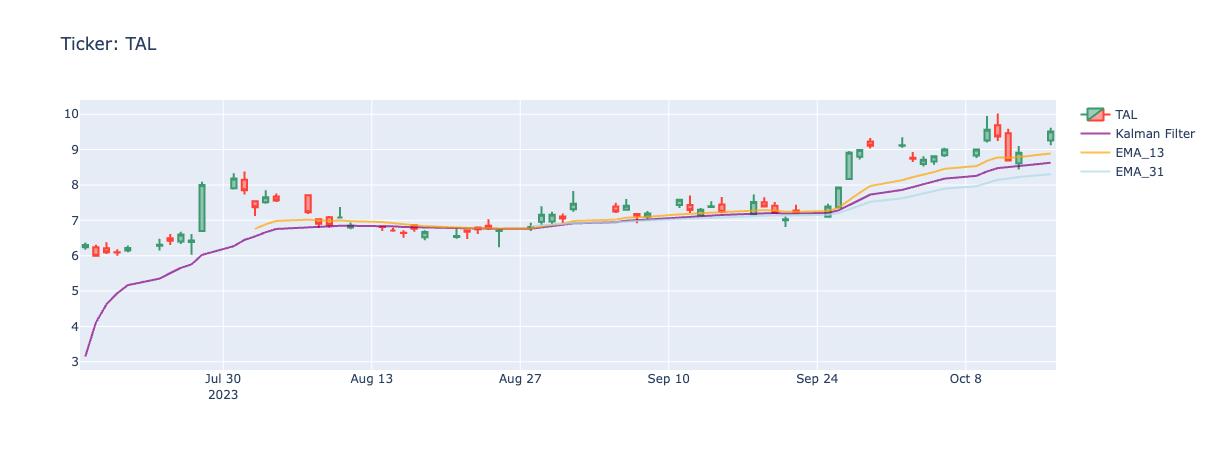

Ticker: VRNS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 32.45000076293945

Ichimoku 9-Day Forecast: 31.287500381469727

Ichimoku 26-Day Forecast: 31.070000648498535

Choppiness (%): 46.38

RSI: 64.44725477160772

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

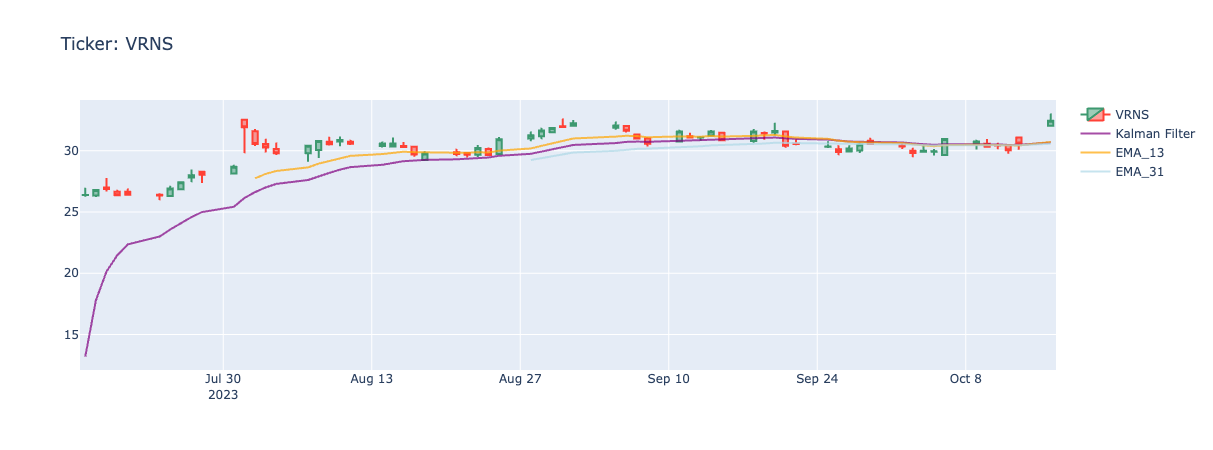

Ticker: TME

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 6.925000190734863

Ichimoku 9-Day Forecast: 6.509999990463257

Ichimoku 26-Day Forecast: 6.444999933242798

Choppiness (%): 48.43

RSI: 63.526743083234656

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

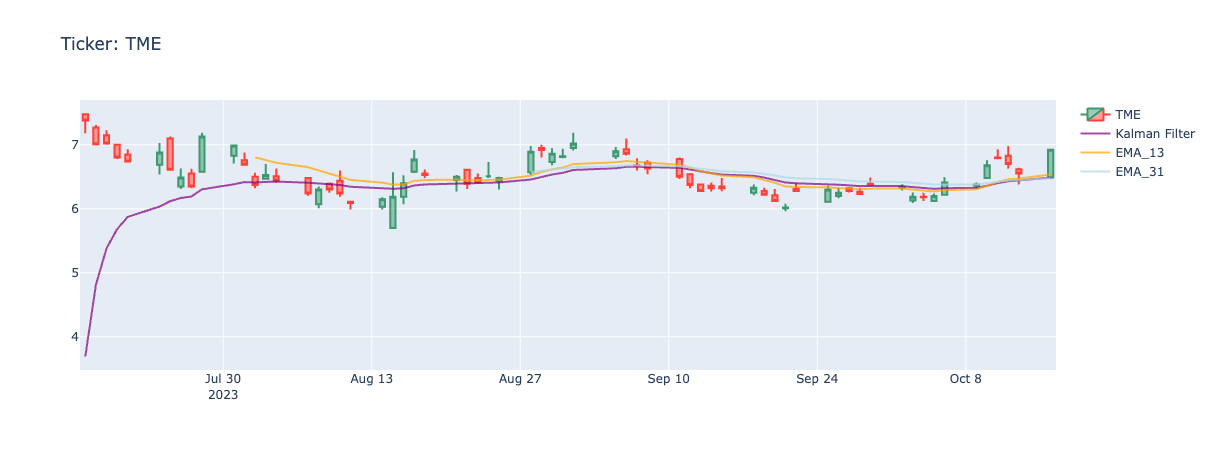

Ticker: TDS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 18.8799991607666

Ichimoku 9-Day Forecast: 17.40000009536743

Ichimoku 26-Day Forecast: 14.694999933242798

Choppiness (%): 43.30

RSI: 62.24325954109975

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

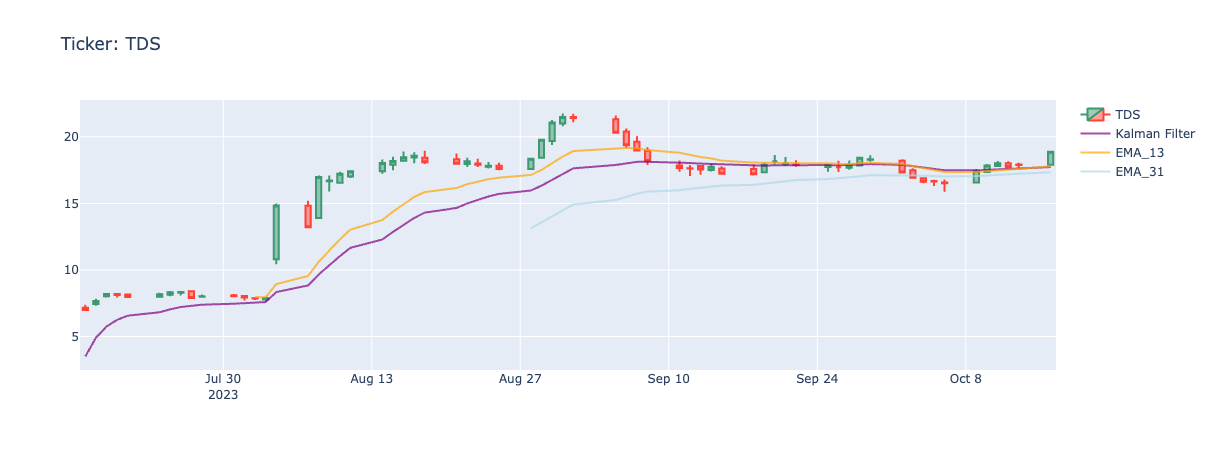

Ticker: USM

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 43.61000061035156

Ichimoku 9-Day Forecast: 40.960225105285645

Ichimoku 26-Day Forecast: 31.950000762939453

Choppiness (%): 48.45

RSI: 61.78075171091854

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

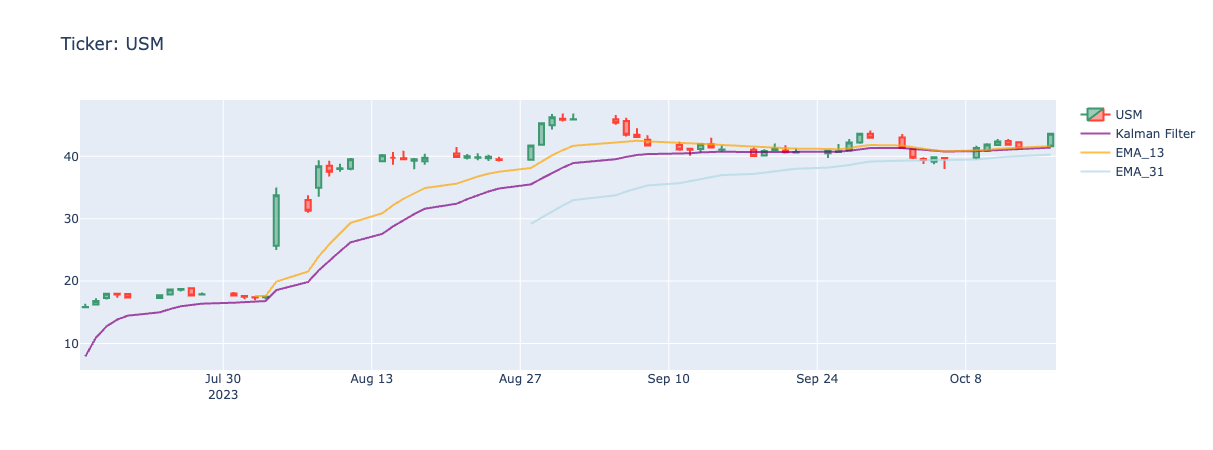

Ticker: AEO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 17.735000610351562

Ichimoku 9-Day Forecast: 16.447500467300415

Ichimoku 26-Day Forecast: 16.09000015258789

Choppiness (%): 45.49

RSI: 68.1792670371989

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

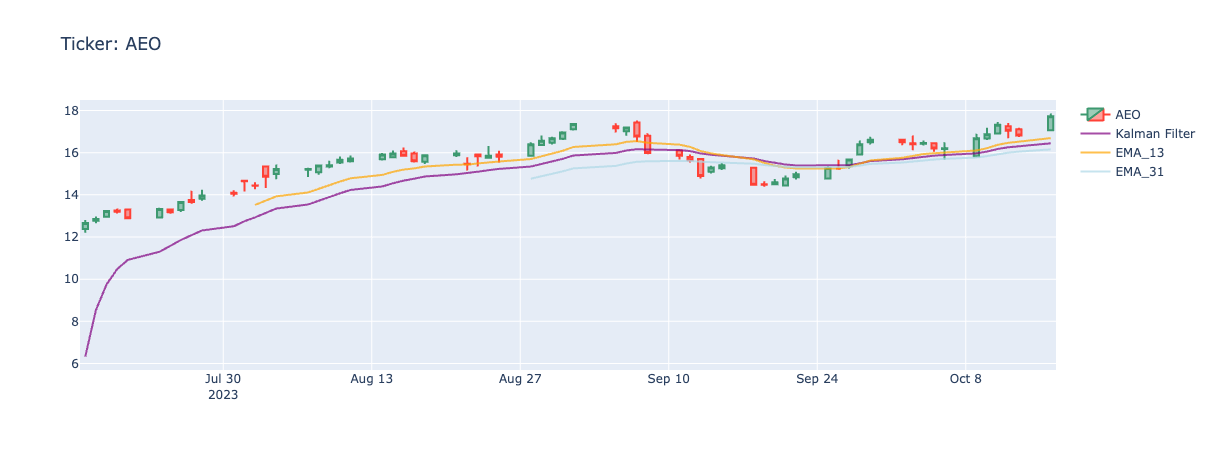

Ticker: ANGPY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 6.775000095367432

Ichimoku 9-Day Forecast: 5.940000057220459

Ichimoku 26-Day Forecast: 6.209500074386597

Choppiness (%): 35.78

RSI: 63.1319371039335

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

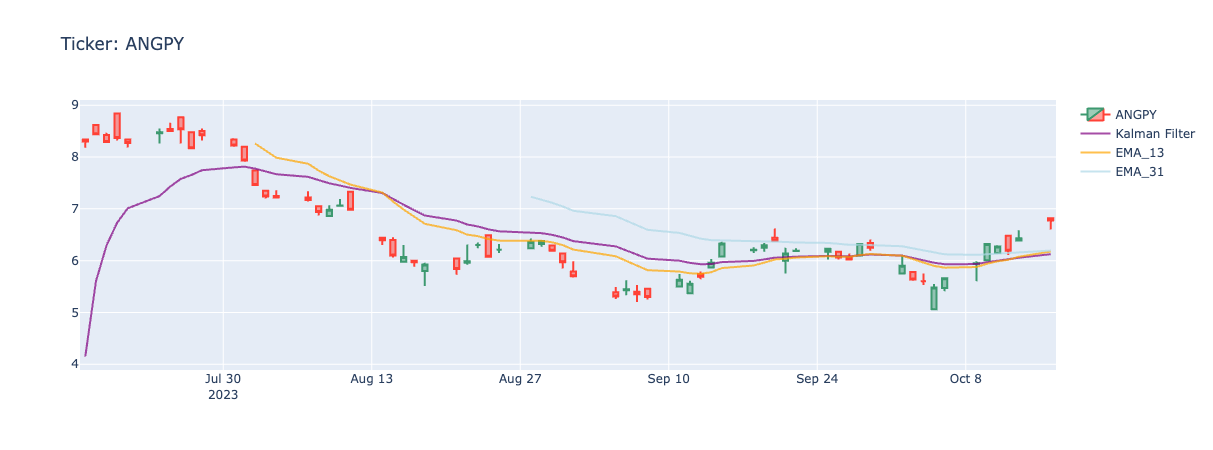

Ticker: GPS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 11.960000038146973

Ichimoku 9-Day Forecast: 10.860000133514404

Ichimoku 26-Day Forecast: 10.695000171661377

Choppiness (%): 39.07

RSI: 65.6842345628761

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

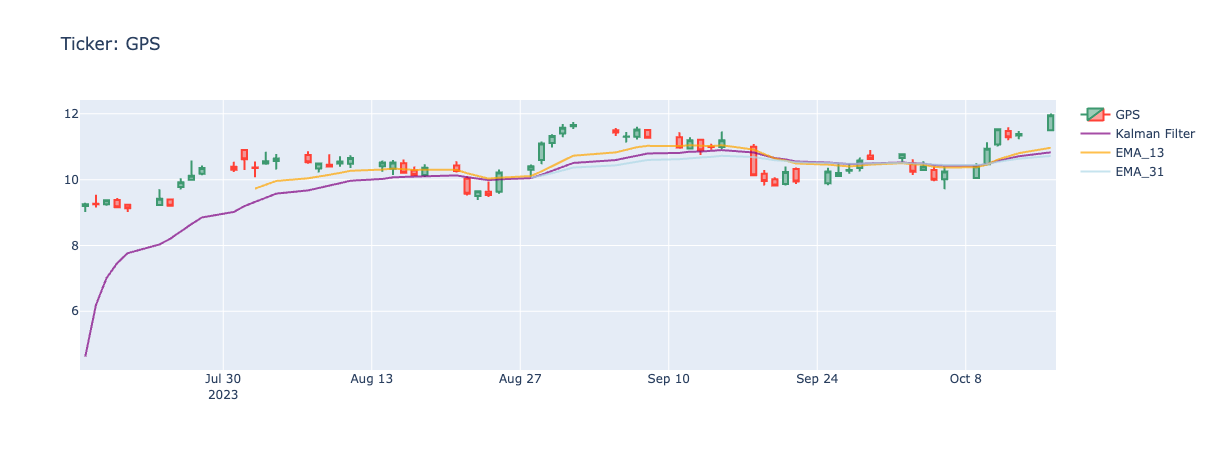

Ticker: FL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 21.790000915527344

Ichimoku 9-Day Forecast: 19.582499980926514

Ichimoku 26-Day Forecast: 20.670000076293945

Choppiness (%): 28.53

RSI: 68.94972712742059

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

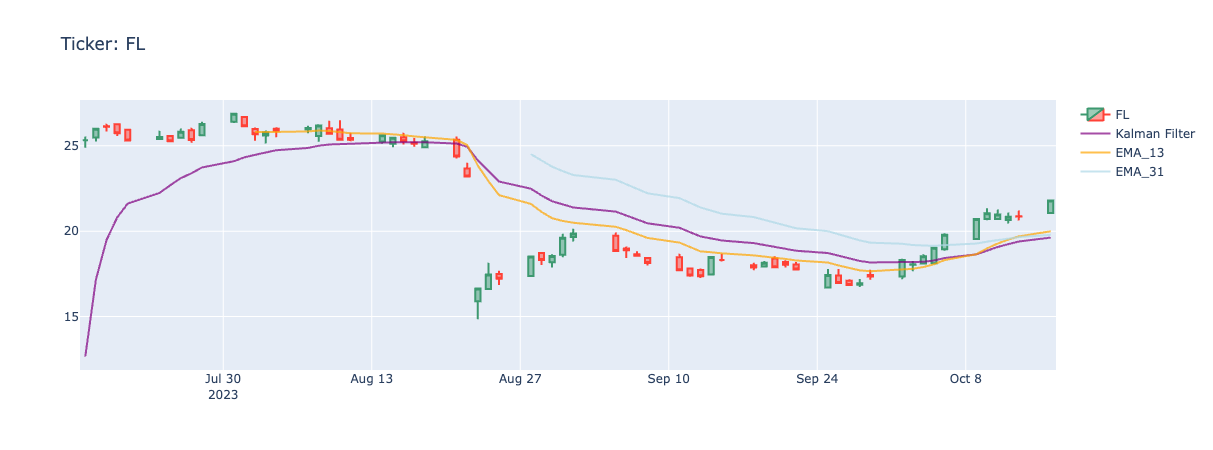

Ticker: AVAV

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 116.33000183105469

Ichimoku 9-Day Forecast: 110.5

Ichimoku 26-Day Forecast: 107.79000091552734

Choppiness (%): 55.75

RSI: 66.1852779623101

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

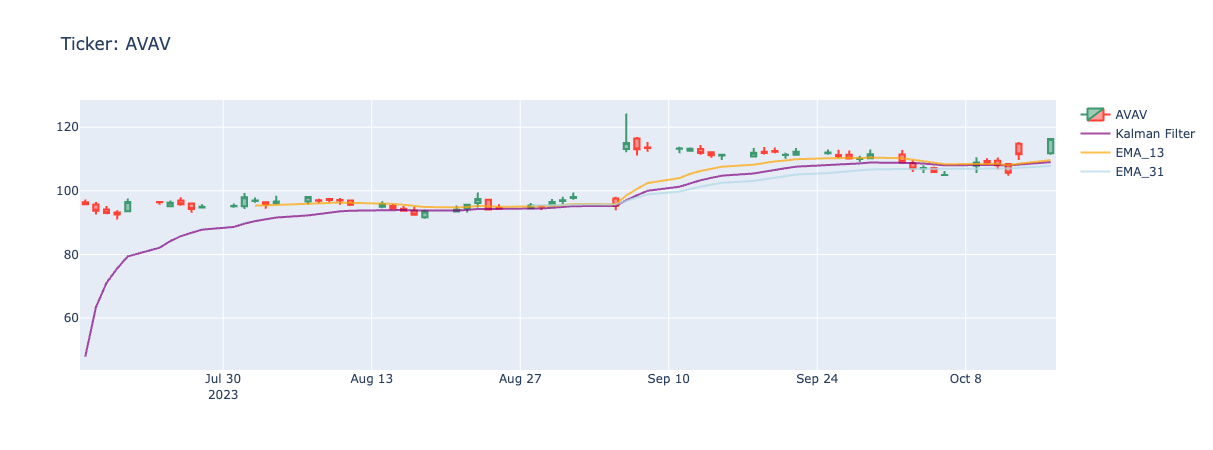

Ticker: WNS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 70.77999877929688

Ichimoku 9-Day Forecast: 69.93500137329102

Ichimoku 26-Day Forecast: 67.67000198364258

Choppiness (%): 55.41

RSI: 59.585703460065396

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

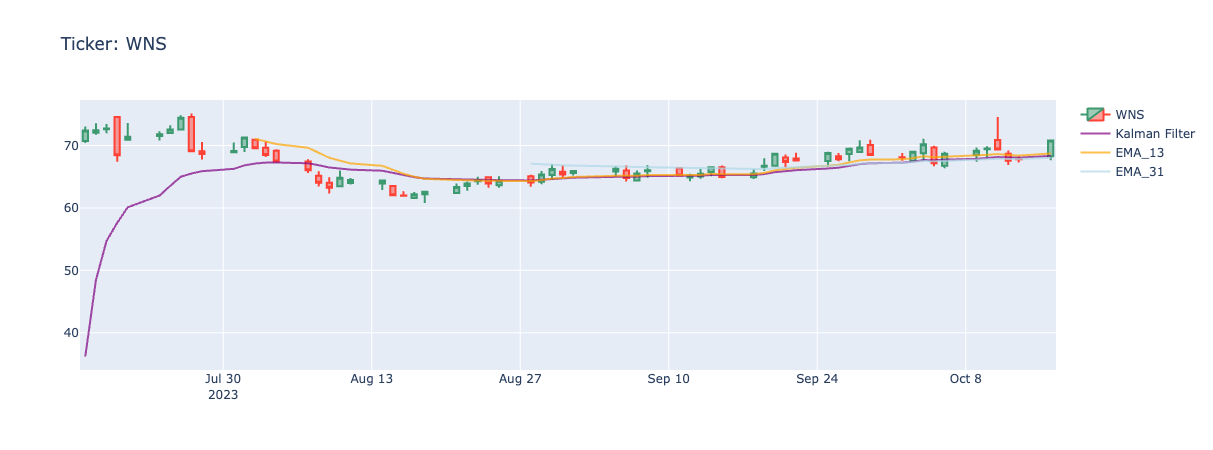

Ticker: PNFP

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 68.6500015258789

Ichimoku 9-Day Forecast: 66.00750160217285

Ichimoku 26-Day Forecast: 69.95499801635742

Choppiness (%): 58.08

RSI: 56.906316697324904

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

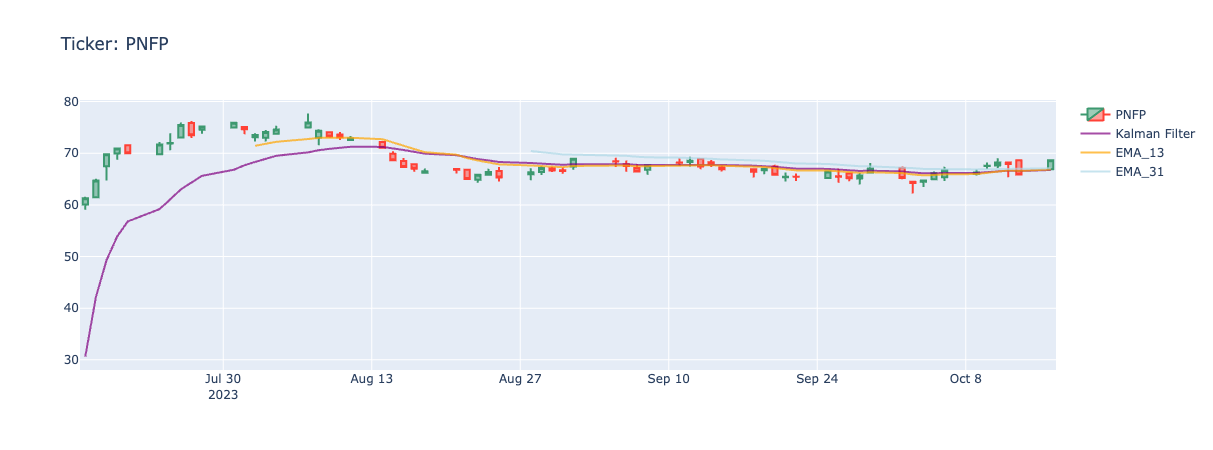

Ticker: S

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 17.184999465942383

Ichimoku 9-Day Forecast: 16.713749647140503

Ichimoku 26-Day Forecast: 16.110000133514404

Choppiness (%): 64.67

RSI: 56.19158563573915

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

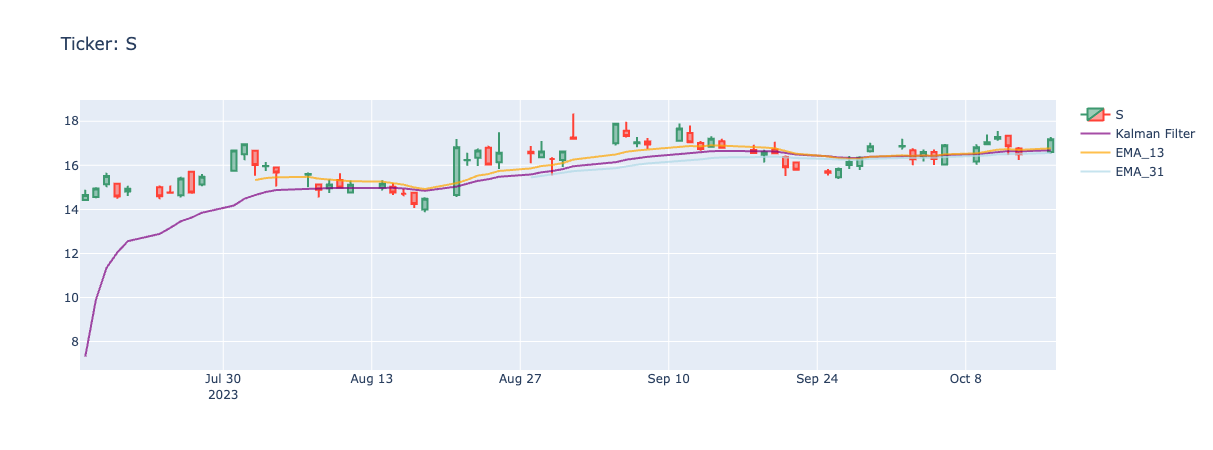

Ticker: FMCC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 0.6420000195503235

Ichimoku 9-Day Forecast: 0.6024999916553497

Ichimoku 26-Day Forecast: 0.6299999952316284

Choppiness (%): 46.25

RSI: 61.04100209542453

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

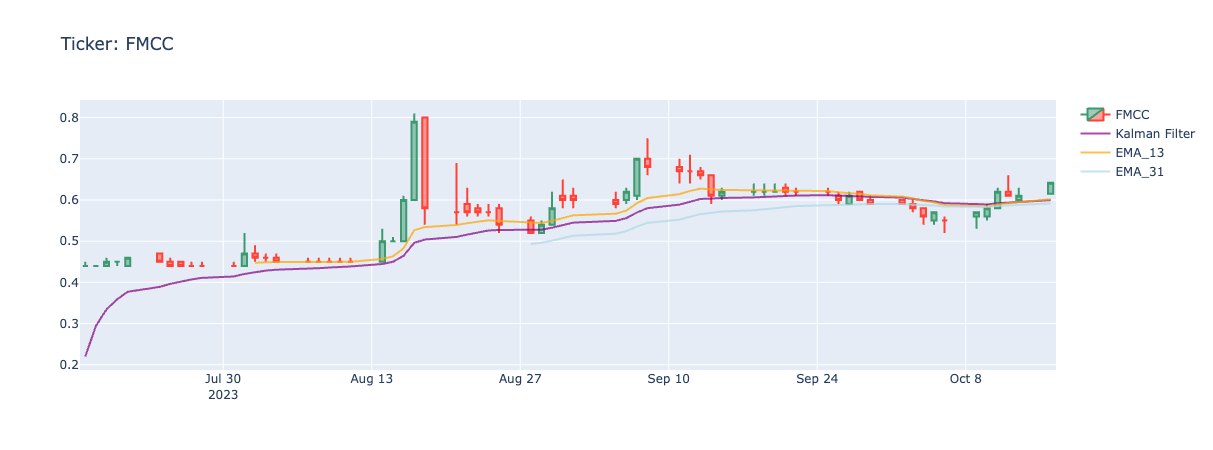

In [26]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output forecasts, 
# RSI, choppiness, trend archers, & other conditionals to aid in decision making.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today - first page.

url = 'https://finance.yahoo.com/gainers?count=100&offset=0'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-1].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
print('\n Entry Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if calculate_symbol(v)[8] == True:
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

# Exit Points

Exit Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: BDORY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 9.119999885559082

Ichimoku 9-Day Forecast: 9.341249942779541

Ichimoku 26-Day Forecast: 9.565000057220459

Choppiness (%): 60.24

RSI: 43.256427011319246

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

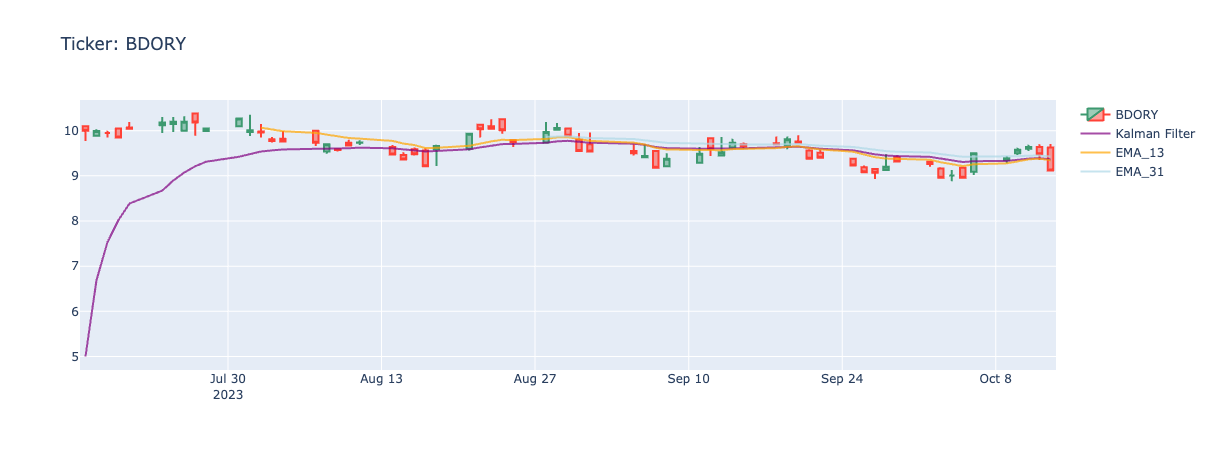

Ticker: BB

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 3.7100000381469727

Ichimoku 9-Day Forecast: 4.235000014305115

Ichimoku 26-Day Forecast: 4.5950000286102295

Choppiness (%): 25.11

RSI: 31.25332352291793

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

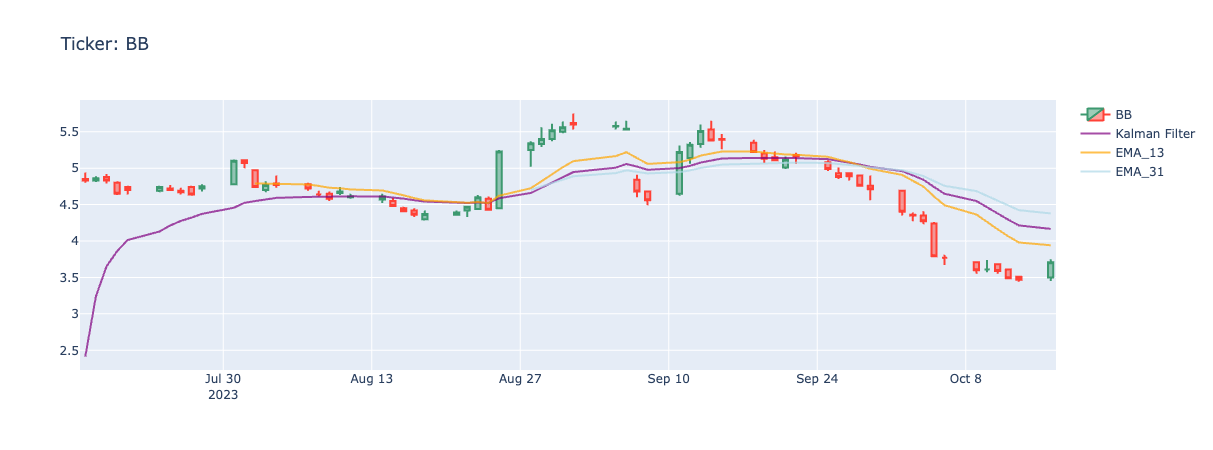

Ticker: BURL

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 124.56999969482422

Ichimoku 9-Day Forecast: 129.68000030517578

Ichimoku 26-Day Forecast: 146.2050018310547

Choppiness (%): 40.31

RSI: 38.486687000669846

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

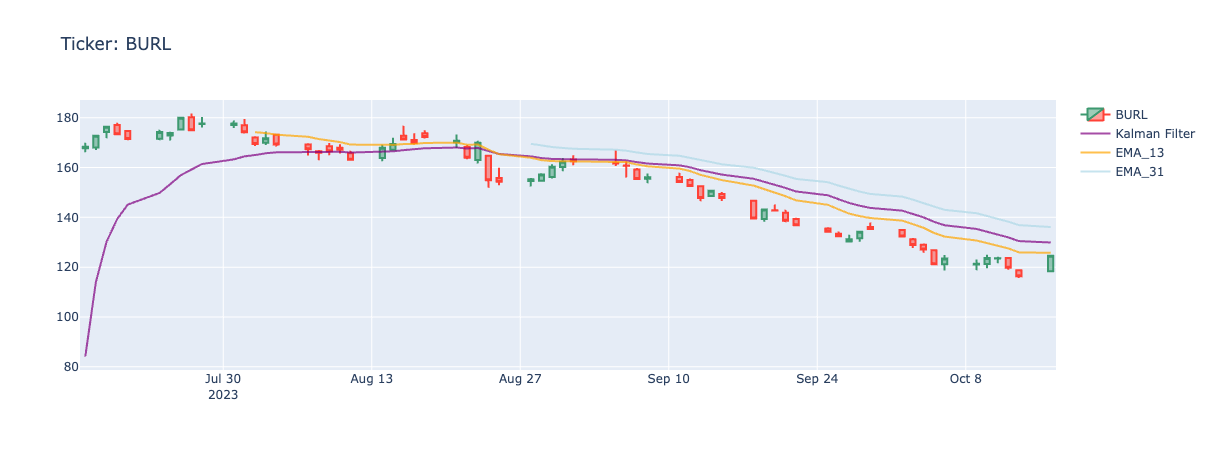

Ticker: WOLF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 34.900001525878906

Ichimoku 9-Day Forecast: 35.57499885559082

Ichimoku 26-Day Forecast: 45.65499973297119

Choppiness (%): 45.32

RSI: 41.7272966556685

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

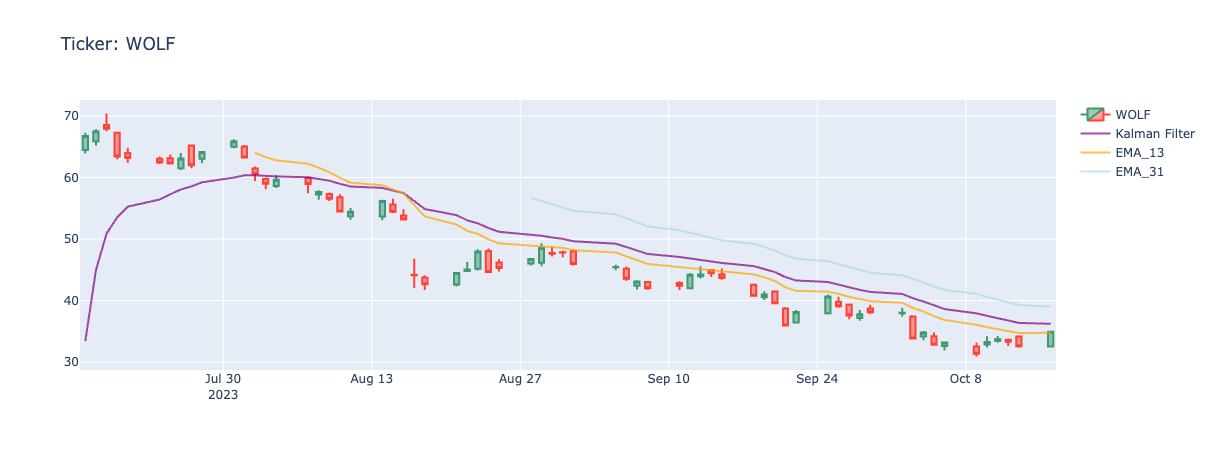

Ticker: KSS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 19.037500381469727

Ichimoku 9-Day Forecast: 20.02750015258789

Ichimoku 26-Day Forecast: 23.664999961853027

Choppiness (%): 45.05

RSI: 39.5401612945681

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

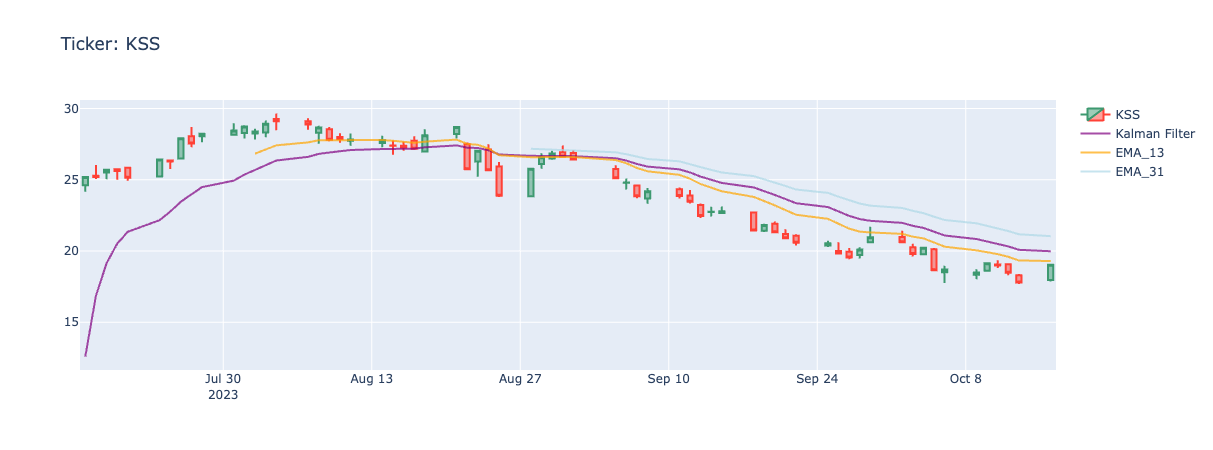

Ticker: ONON

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 25.290000915527344

Ichimoku 9-Day Forecast: 26.146999835968018

Ichimoku 26-Day Forecast: 30.2450008392334

Choppiness (%): 47.09

RSI: 42.02086177136187

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

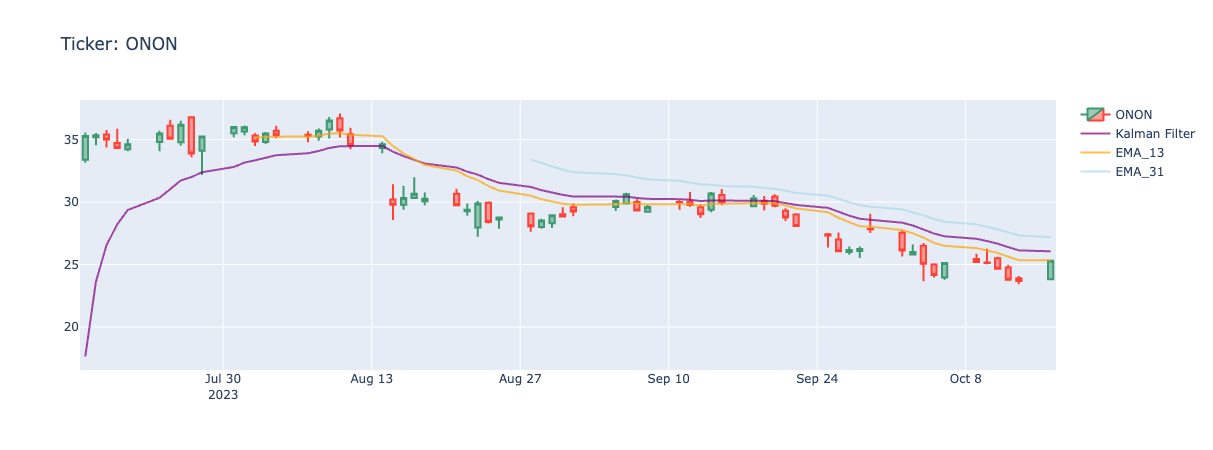

Ticker: ACVA

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 14.680000305175781

Ichimoku 9-Day Forecast: 14.895000219345093

Ichimoku 26-Day Forecast: 15.535000324249268

Choppiness (%): 54.54

RSI: 46.18646307019041

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

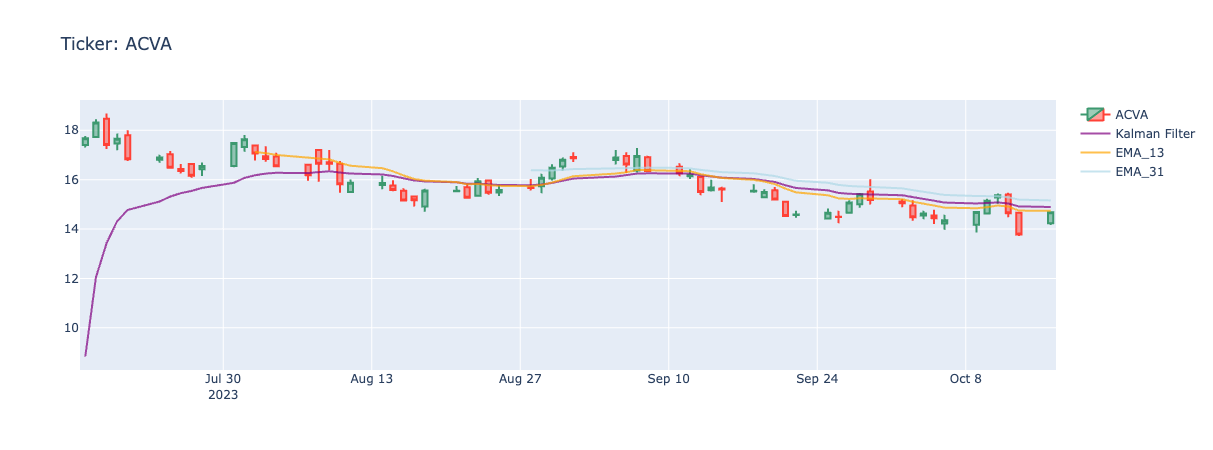

Ticker: FSLY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 15.555000305175781

Ichimoku 9-Day Forecast: 17.795000076293945

Ichimoku 26-Day Forecast: 19.454999923706055

Choppiness (%): 41.76

RSI: 35.158168831009306

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

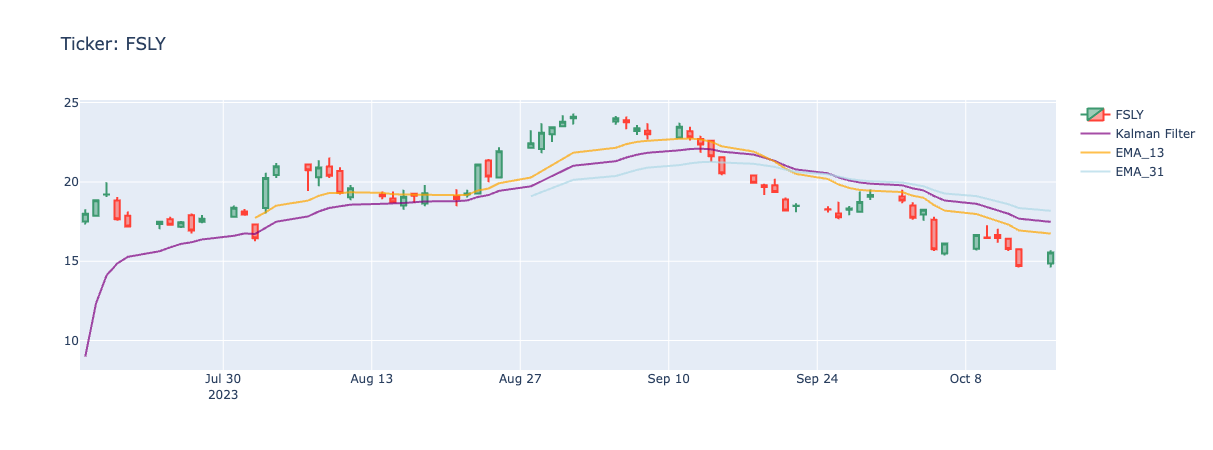

Ticker: LGGNF

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 2.700000047683716

Ichimoku 9-Day Forecast: 2.6575000286102295

Ichimoku 26-Day Forecast: 2.7899999618530273

Choppiness (%): 68.40

RSI: 51.101585178326346

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

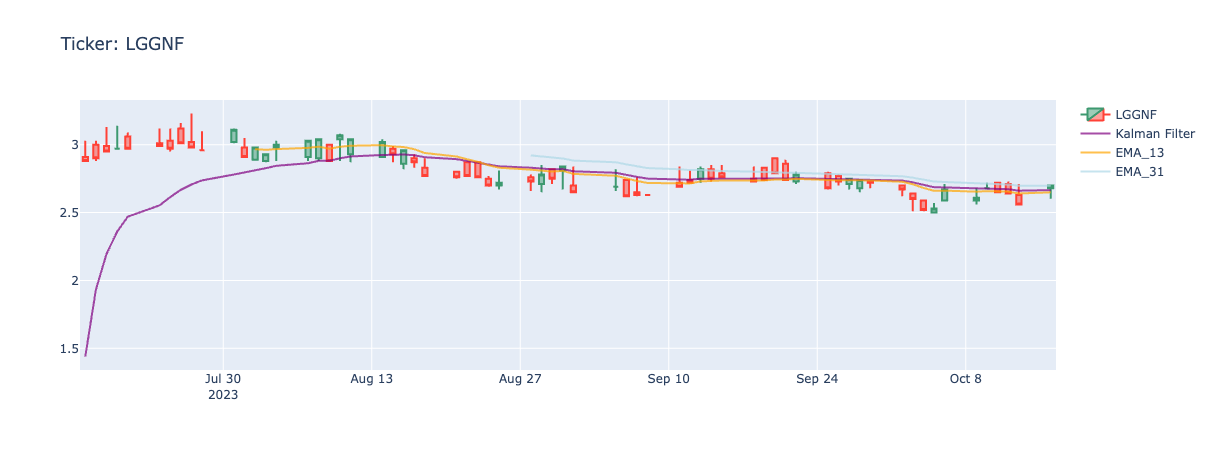

Ticker: BDC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 74.87000274658203

Ichimoku 9-Day Forecast: 82.77249908447266

Ichimoku 26-Day Forecast: 82.94499969482422

Choppiness (%): 24.25

RSI: 26.413379891287544

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

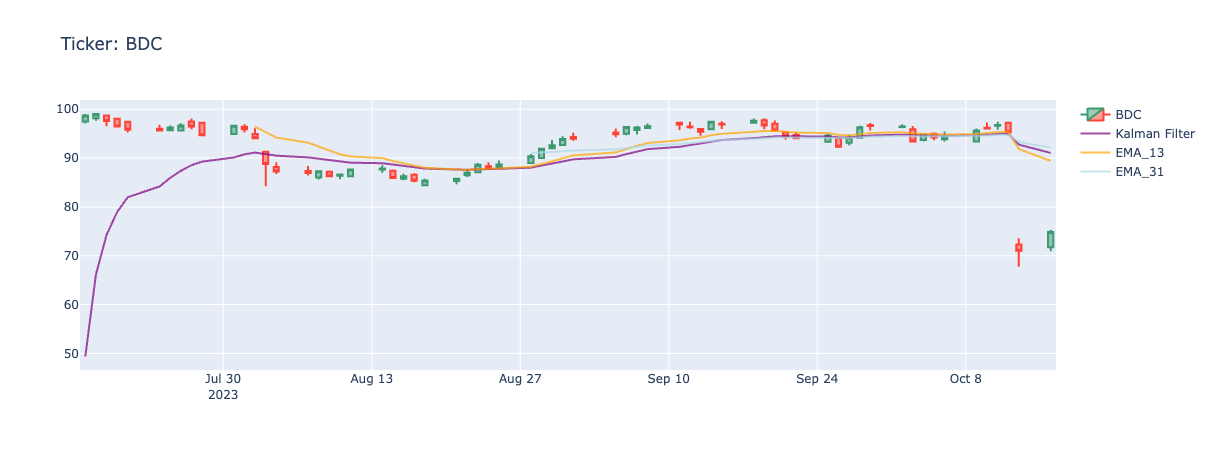

Ticker: PATH

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 16.219999313354492

Ichimoku 9-Day Forecast: 16.91249990463257

Ichimoku 26-Day Forecast: 16.759999752044678

Choppiness (%): 61.83

RSI: 47.00899465996229

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

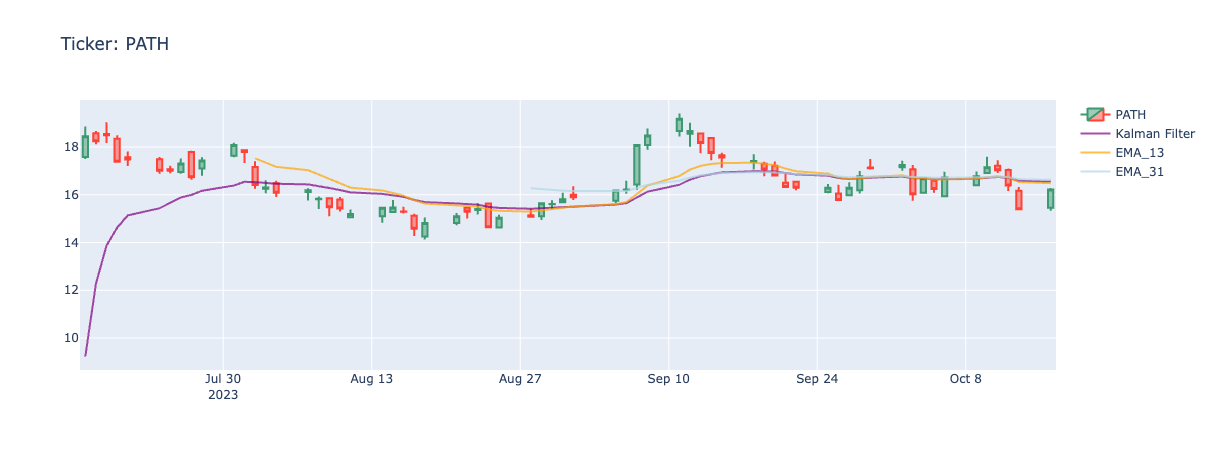

Ticker: PWSC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 21.695999145507812

Ichimoku 9-Day Forecast: 21.934999465942383

Ichimoku 26-Day Forecast: 22.34999942779541

Choppiness (%): 51.93

RSI: 46.51280257971352

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

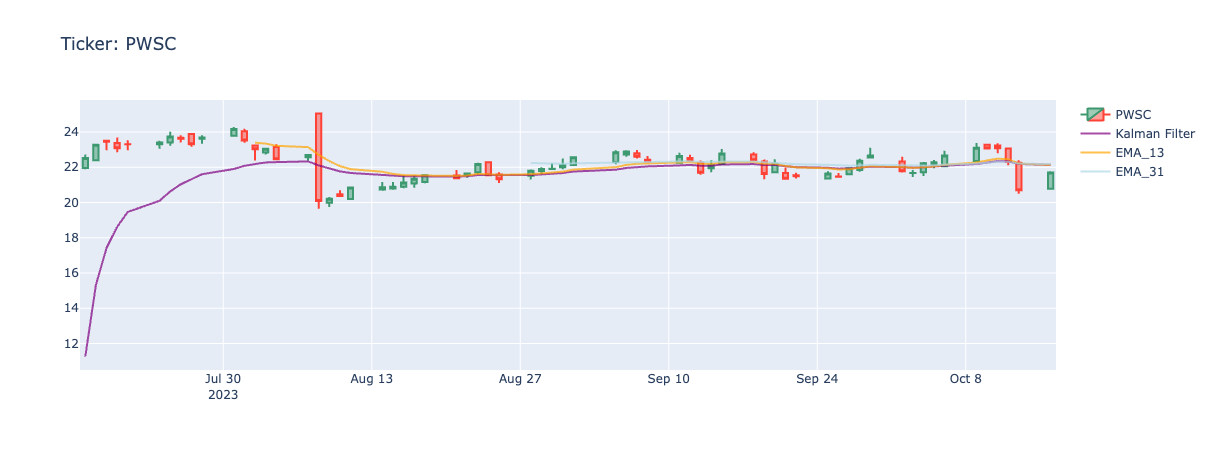

Ticker: NICE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 166.89239501953125

Ichimoku 9-Day Forecast: 169.12249755859375

Ichimoku 26-Day Forecast: 191.45999908447266

Choppiness (%): 58.12

RSI: 41.612696113607036

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

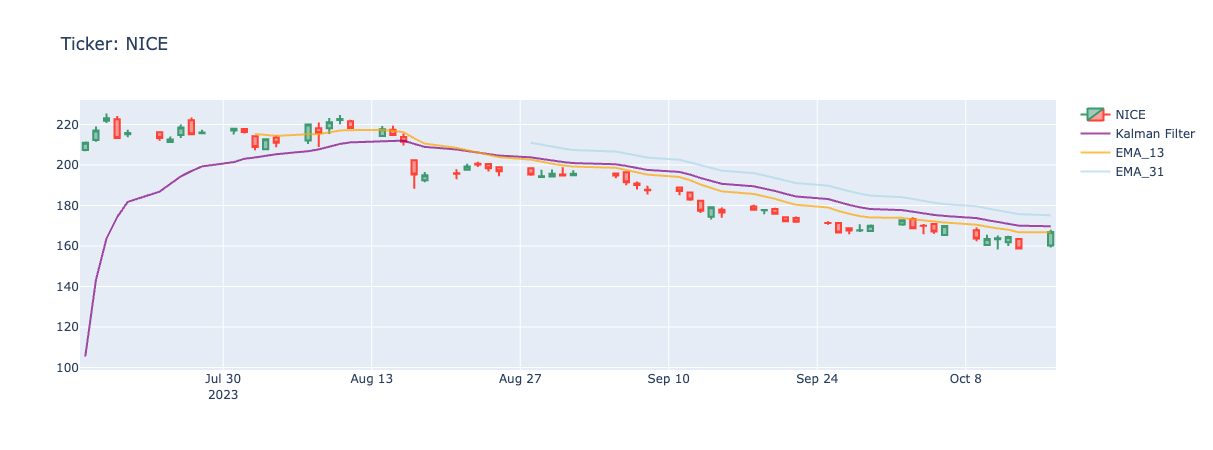

Ticker: FIVN

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 63.314998626708984

Ichimoku 9-Day Forecast: 63.546247482299805

Ichimoku 26-Day Forecast: 71.1240005493164

Choppiness (%): 56.47

RSI: 45.006392847427435

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

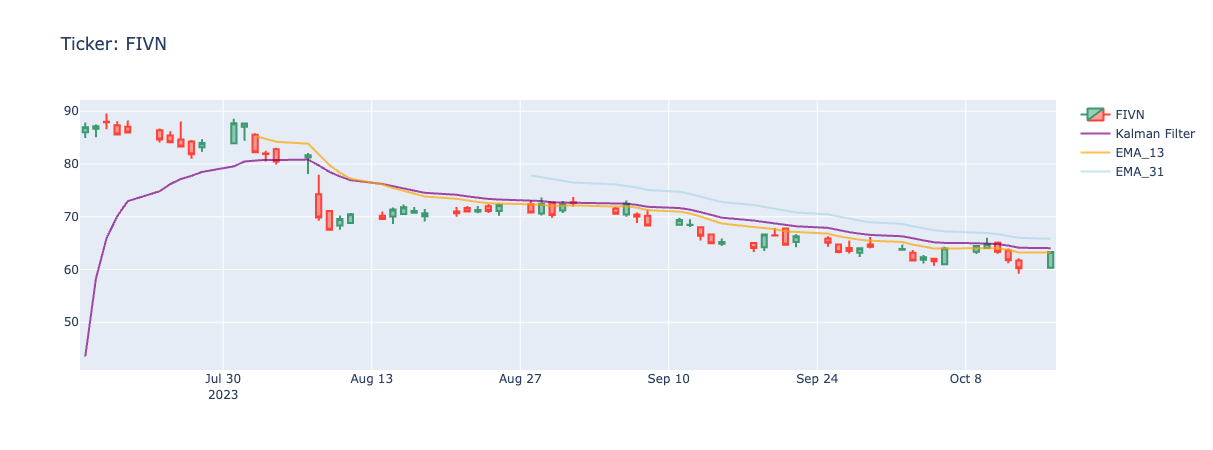

Ticker: UPST

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 28.639999389648438

Ichimoku 9-Day Forecast: 28.165499687194824

Ichimoku 26-Day Forecast: 48.06400108337402

Choppiness (%): 58.71

RSI: 47.09009153390963

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

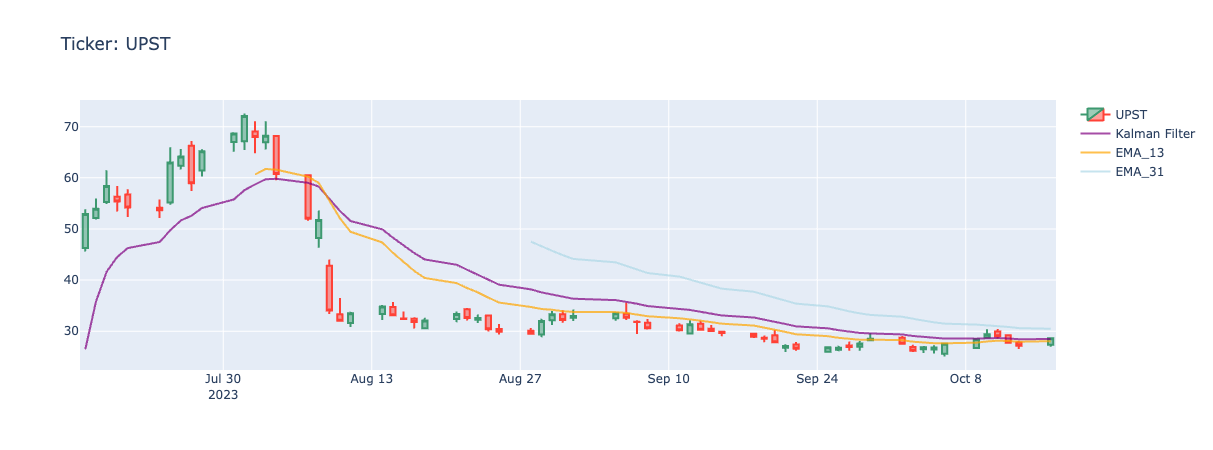

Ticker: PFE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 33.65999984741211

Ichimoku 9-Day Forecast: 33.1225004196167

Ichimoku 26-Day Forecast: 34.47999954223633

Choppiness (%): 58.68

RSI: 51.112946185808

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

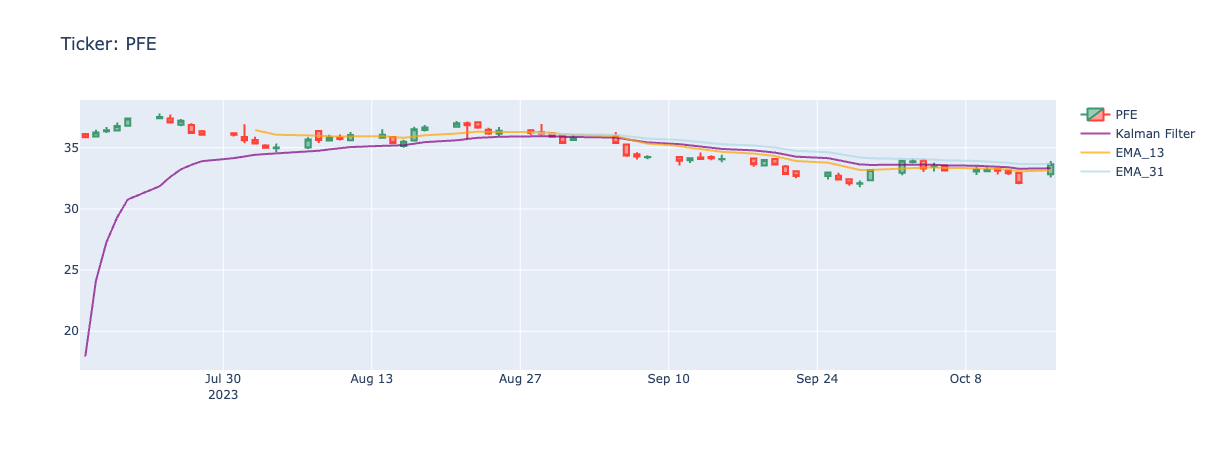

Ticker: NARI

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 58.099998474121094

Ichimoku 9-Day Forecast: 61.71000099182129

Ichimoku 26-Day Forecast: 62.93499946594238

Choppiness (%): 43.30

RSI: 36.82555185524559

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

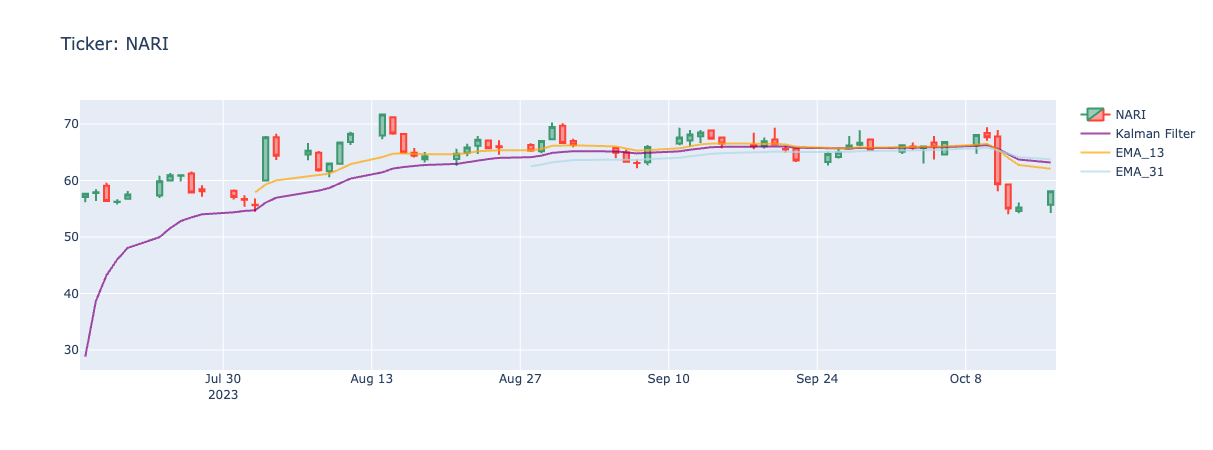

Ticker: IOT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 24.59000015258789

Ichimoku 9-Day Forecast: 25.72100019454956

Ichimoku 26-Day Forecast: 27.149999618530273

Choppiness (%): 59.64

RSI: 45.23182834037802

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

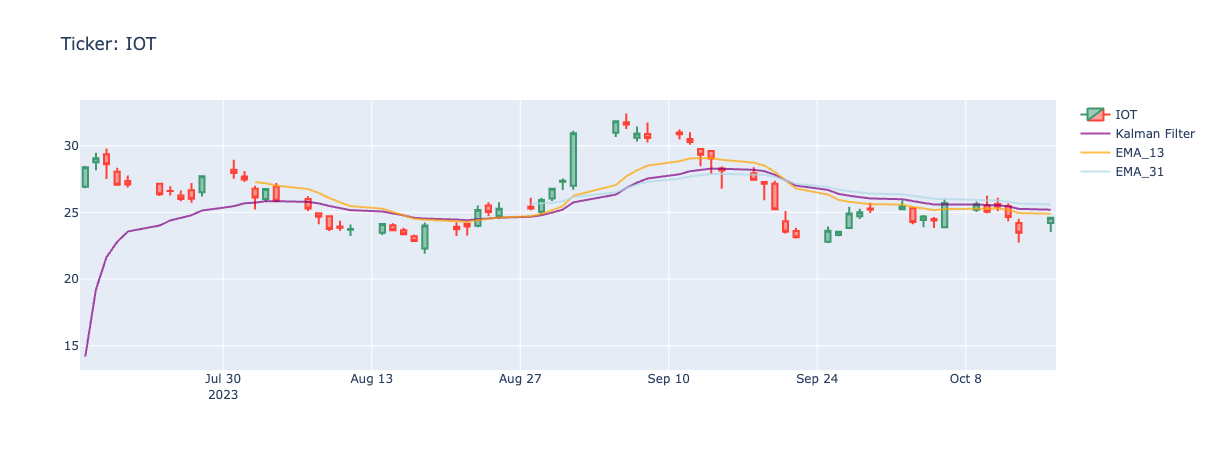

Ticker: ASO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 45.38399887084961

Ichimoku 9-Day Forecast: 45.76750087738037

Ichimoku 26-Day Forecast: 51.52250099182129

Choppiness (%): 48.26

RSI: 44.101756799528005

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

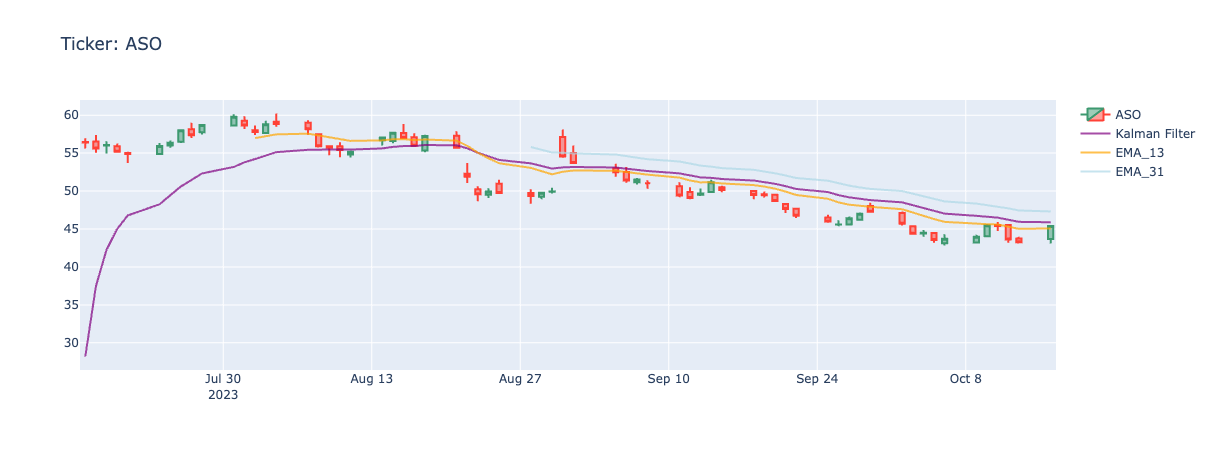

Ticker: YOU

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 17.530000686645508

Ichimoku 9-Day Forecast: 17.473750114440918

Ichimoku 26-Day Forecast: 20.25499963760376

Choppiness (%): 44.70

RSI: 38.81159258699632

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

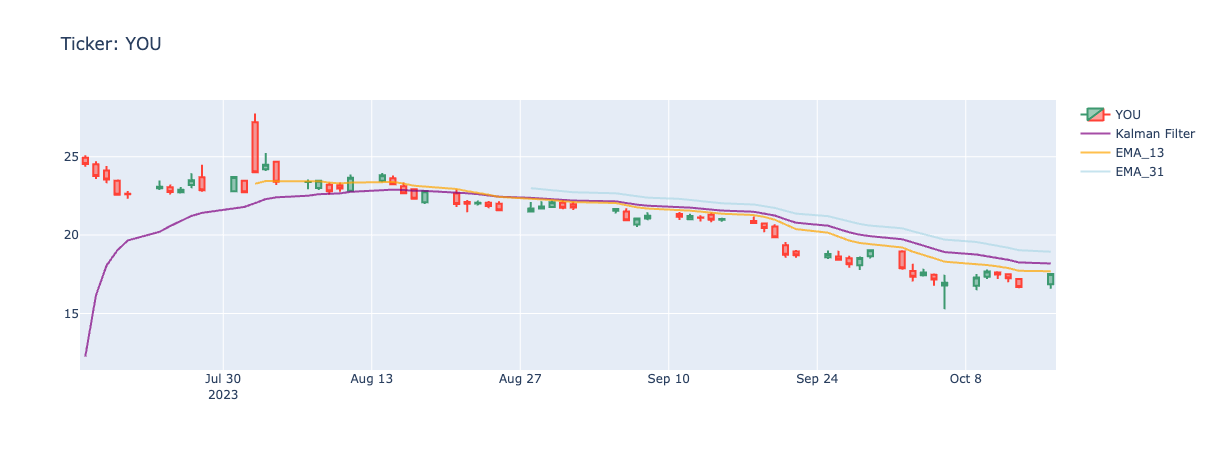

Ticker: NCNO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 29.3799991607666

Ichimoku 9-Day Forecast: 29.896249771118164

Ichimoku 26-Day Forecast: 30.704999923706055

Choppiness (%): 46.03

RSI: 44.42786249168836

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

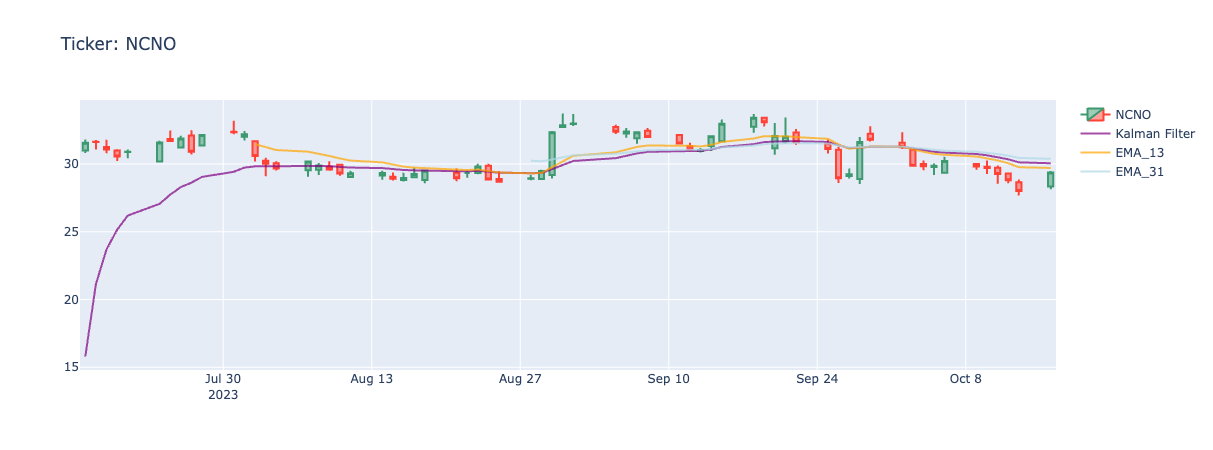

Ticker: DXCM

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 79.58999633789062

Ichimoku 9-Day Forecast: 87.24499893188477

Ichimoku 26-Day Forecast: 99.81499862670898

Choppiness (%): 39.06

RSI: 34.56405014248428

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

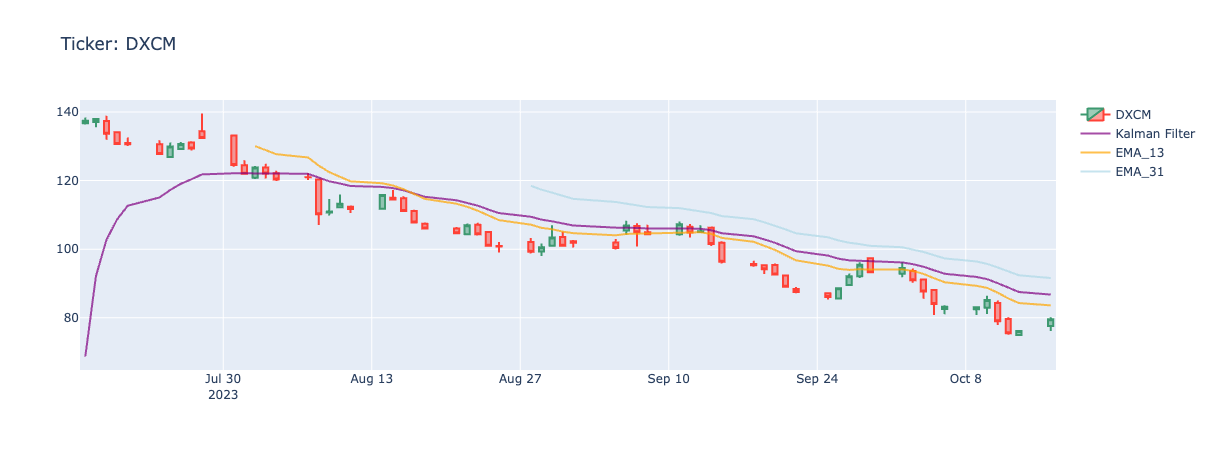

Ticker: MODG

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 13.270000457763672

Ichimoku 9-Day Forecast: 13.974999904632568

Ichimoku 26-Day Forecast: 16.06500005722046

Choppiness (%): 59.81

RSI: 35.274100014933744

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

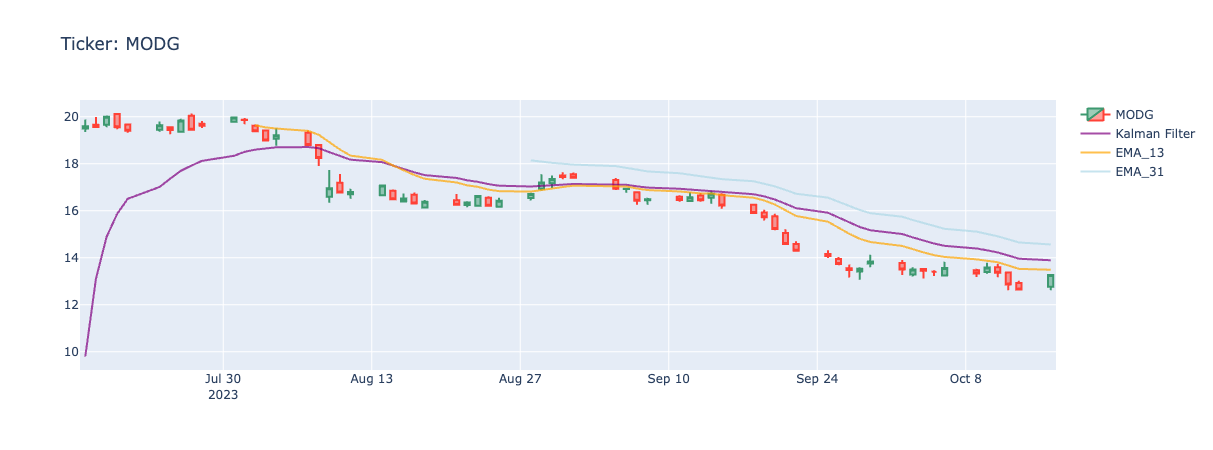

Ticker: DEI

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 12.390000343322754

Ichimoku 9-Day Forecast: 12.299999713897705

Ichimoku 26-Day Forecast: 13.0

Choppiness (%): 57.25

RSI: 47.30855748676458

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

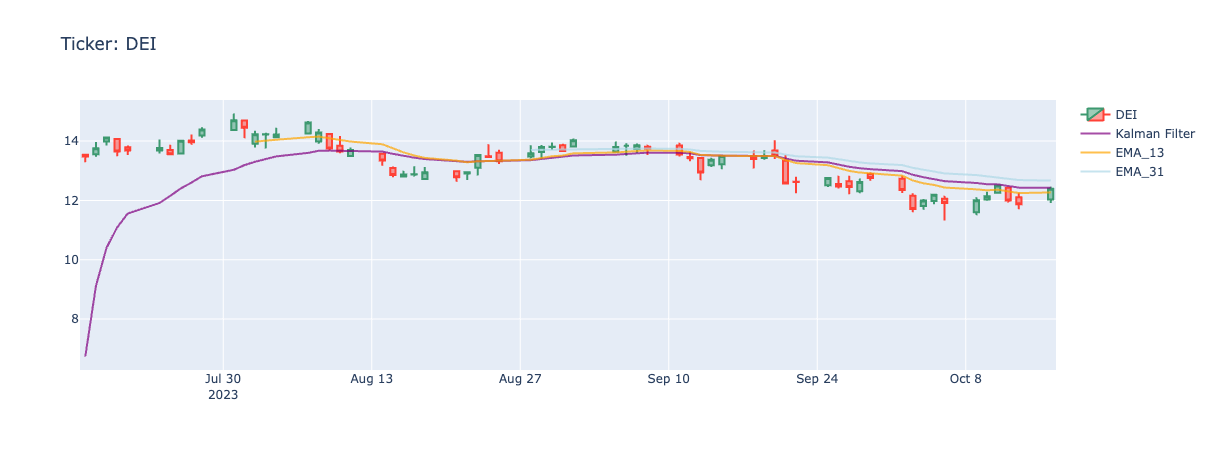

Ticker: TEAM

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 188.30999755859375

Ichimoku 9-Day Forecast: 198.2750015258789

Ichimoku 26-Day Forecast: 191.3810043334961

Choppiness (%): 58.77

RSI: 43.2072157937594

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

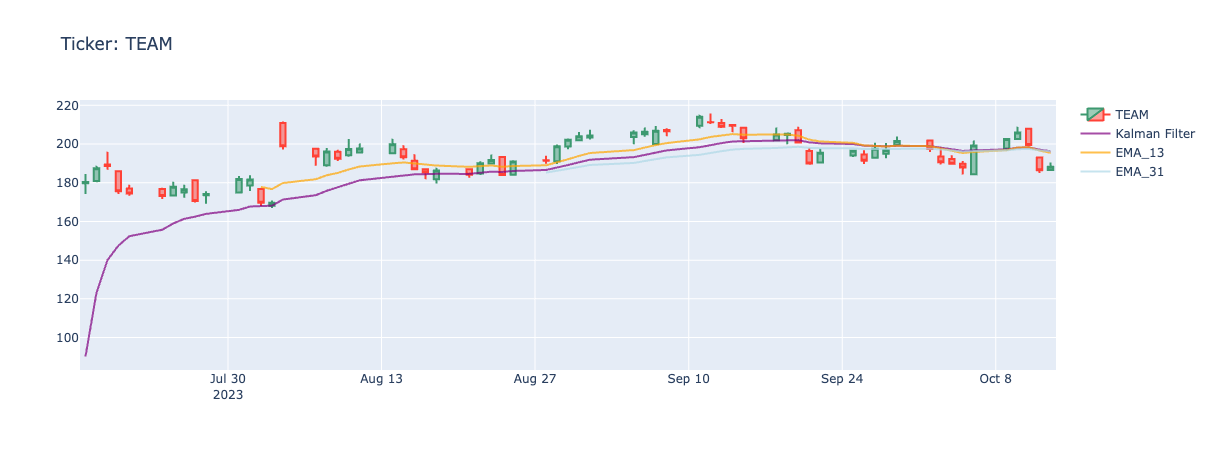

Ticker: AX

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 37.279998779296875

Ichimoku 9-Day Forecast: 38.05000019073486

Ichimoku 26-Day Forecast: 40.75

Choppiness (%): 64.58

RSI: 43.492998725980144

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

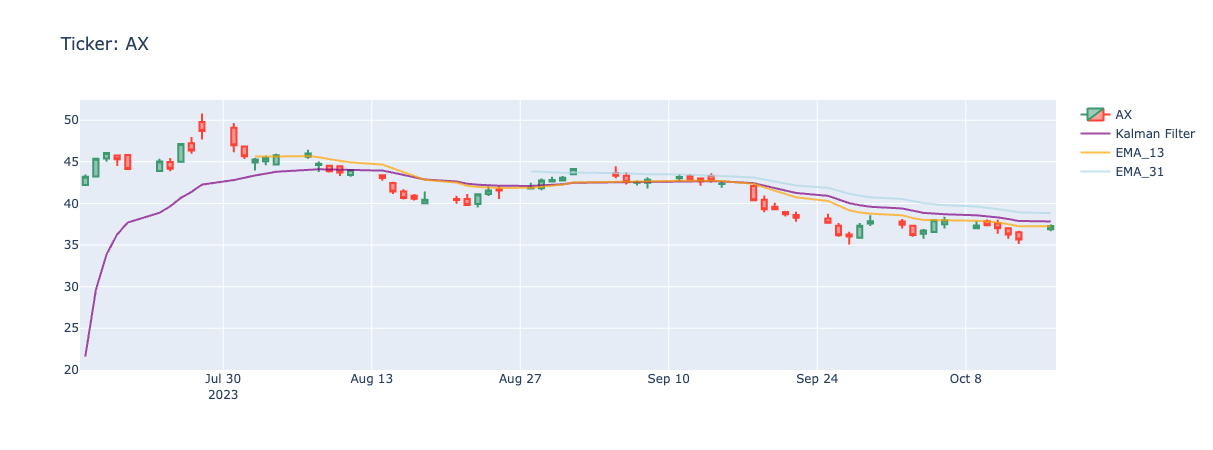

Ticker: SHC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 13.994999885559082

Ichimoku 9-Day Forecast: 14.084999799728394

Ichimoku 26-Day Forecast: 15.694999694824219

Choppiness (%): 40.22

RSI: 39.27474110807235

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

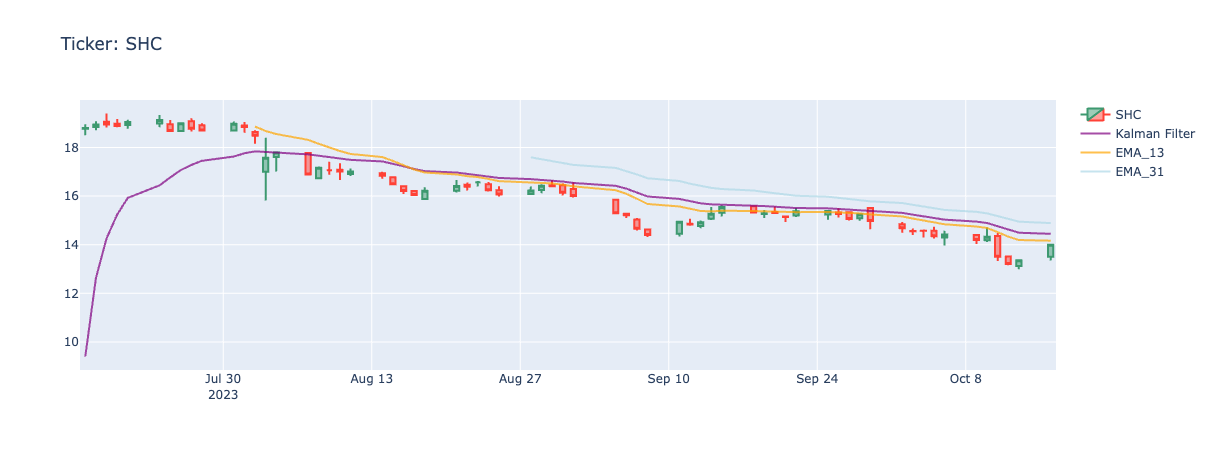

Ticker: BMA

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 18.8700008392334

Ichimoku 9-Day Forecast: 19.865000247955322

Ichimoku 26-Day Forecast: 22.875

Choppiness (%): 48.77

RSI: 35.771697399164545

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

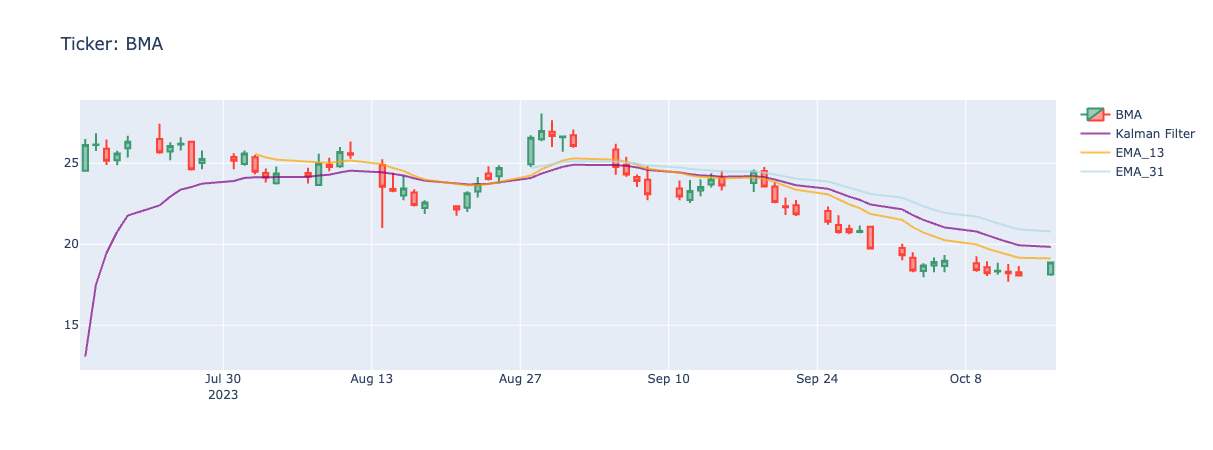

Ticker: VFC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 16.17169952392578

Ichimoku 9-Day Forecast: 16.46999979019165

Ichimoku 26-Day Forecast: 18.139999866485596

Choppiness (%): 51.19

RSI: 42.685396148597526

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

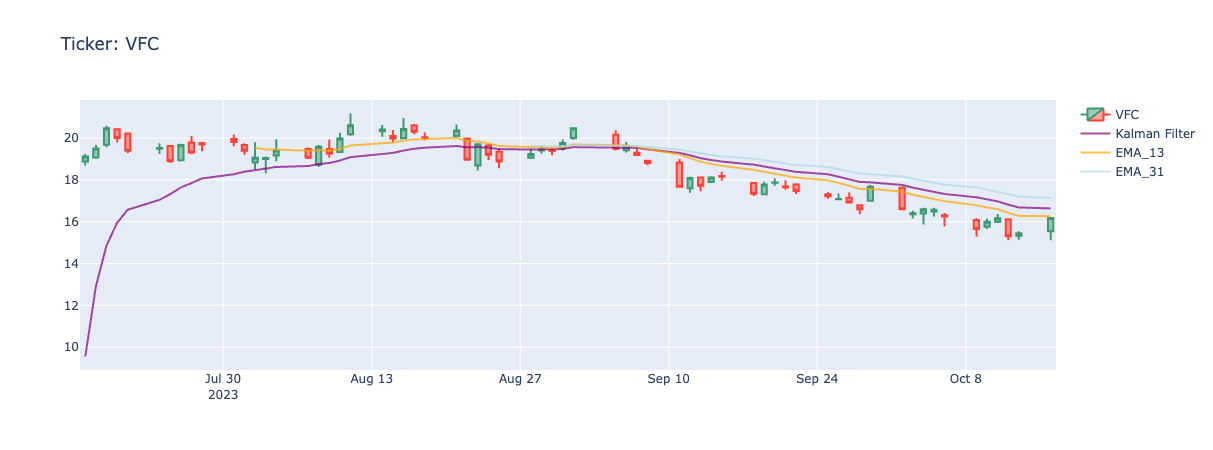

Ticker: NVEI

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 15.619999885559082

Ichimoku 9-Day Forecast: 15.820000171661377

Ichimoku 26-Day Forecast: 22.804999828338623

Choppiness (%): 52.19

RSI: 42.216600431035815

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

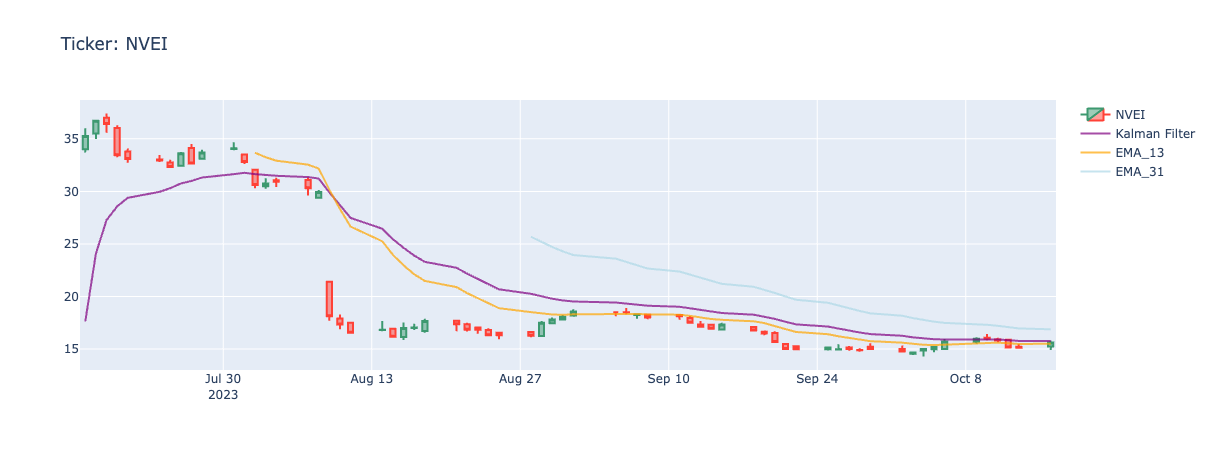

Ticker: FRSH

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 18.584999084472656

Ichimoku 9-Day Forecast: 19.359999656677246

Ichimoku 26-Day Forecast: 20.66249942779541

Choppiness (%): 49.24

RSI: 42.6252305061033

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

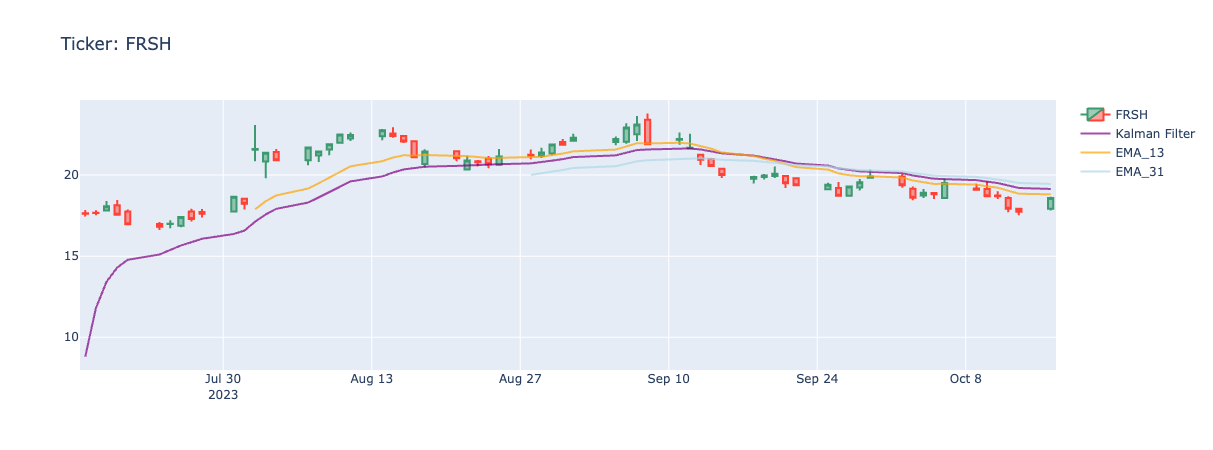

Ticker: VNO

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 21.100000381469727

Ichimoku 9-Day Forecast: 21.989999771118164

Ichimoku 26-Day Forecast: 22.90499973297119

Choppiness (%): 50.67

RSI: 40.14833137595

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

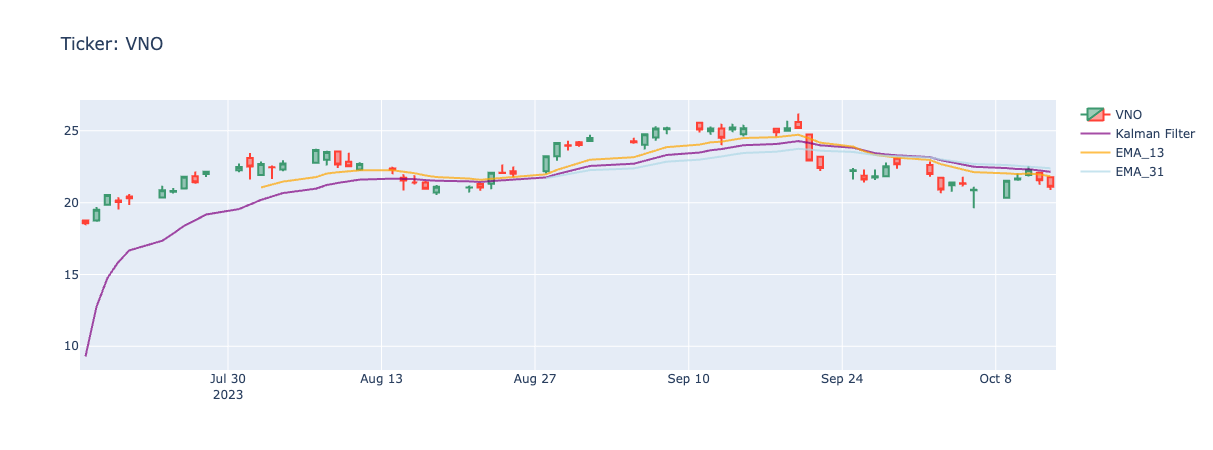

Ticker: CFLT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 30.520000457763672

Ichimoku 9-Day Forecast: 30.642499923706055

Ichimoku 26-Day Forecast: 32.99949932098389

Choppiness (%): 56.69

RSI: 49.16965980973576

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

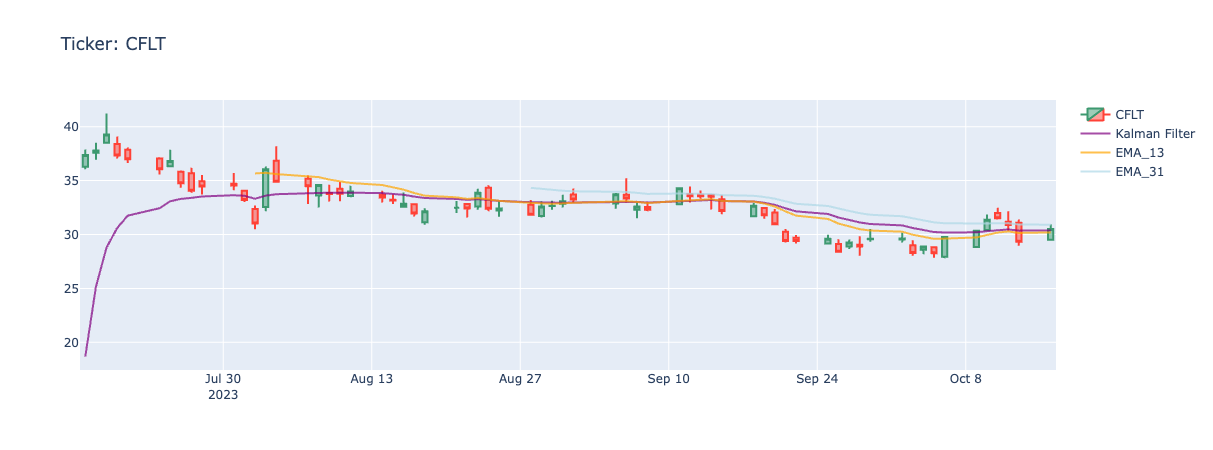

Ticker: LNC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 24.05500030517578

Ichimoku 9-Day Forecast: 24.03749990463257

Ichimoku 26-Day Forecast: 25.859999656677246

Choppiness (%): 56.76

RSI: 47.76059445731527

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

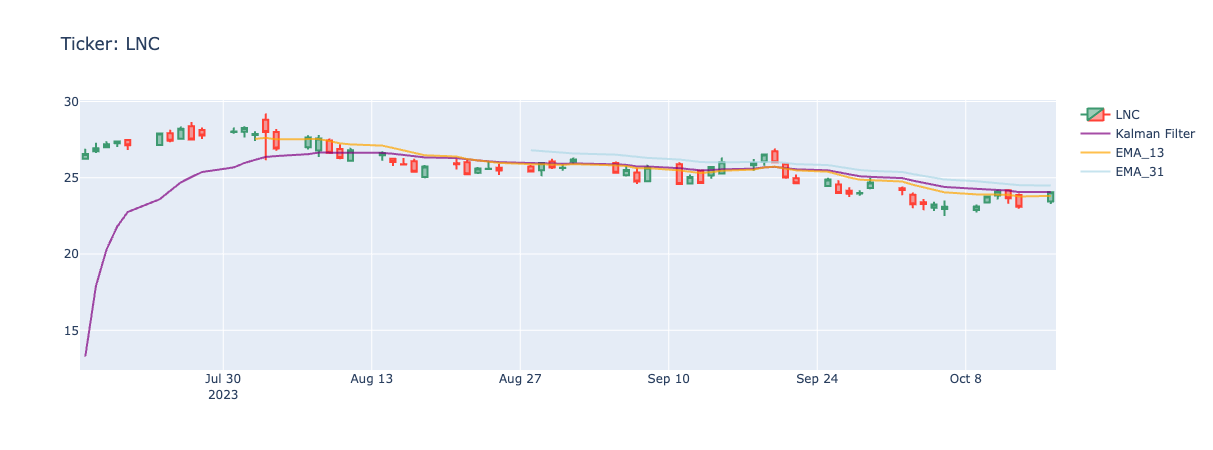

Ticker: BHC

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 7.400000095367432

Ichimoku 9-Day Forecast: 7.807499885559082

Ichimoku 26-Day Forecast: 8.614999771118164

Choppiness (%): 50.52

RSI: 36.266088018630576

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

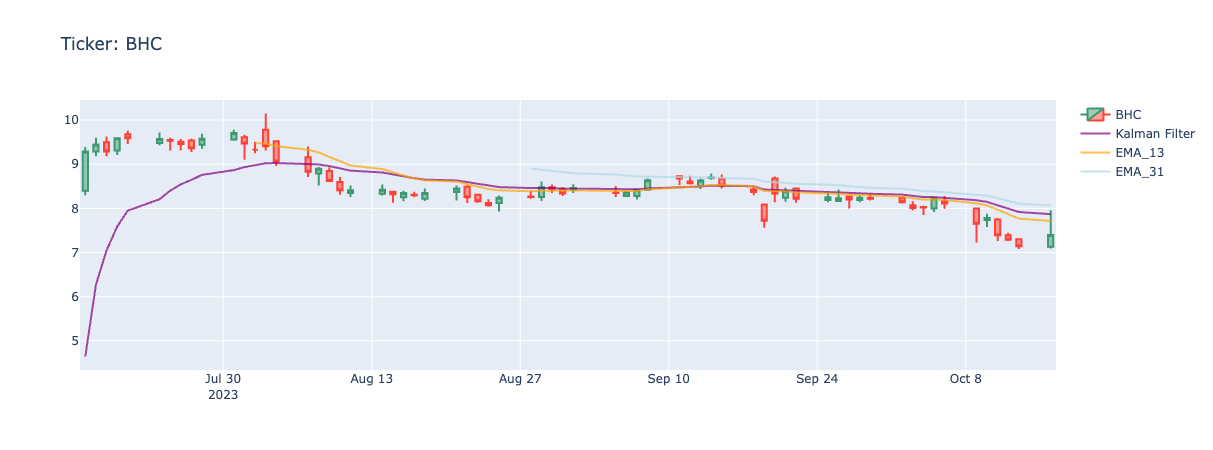

Ticker: HPE

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 17.1200008392334

Ichimoku 9-Day Forecast: 16.994999885559082

Ichimoku 26-Day Forecast: 17.167500495910645

Choppiness (%): 61.38

RSI: 51.33003912234507

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

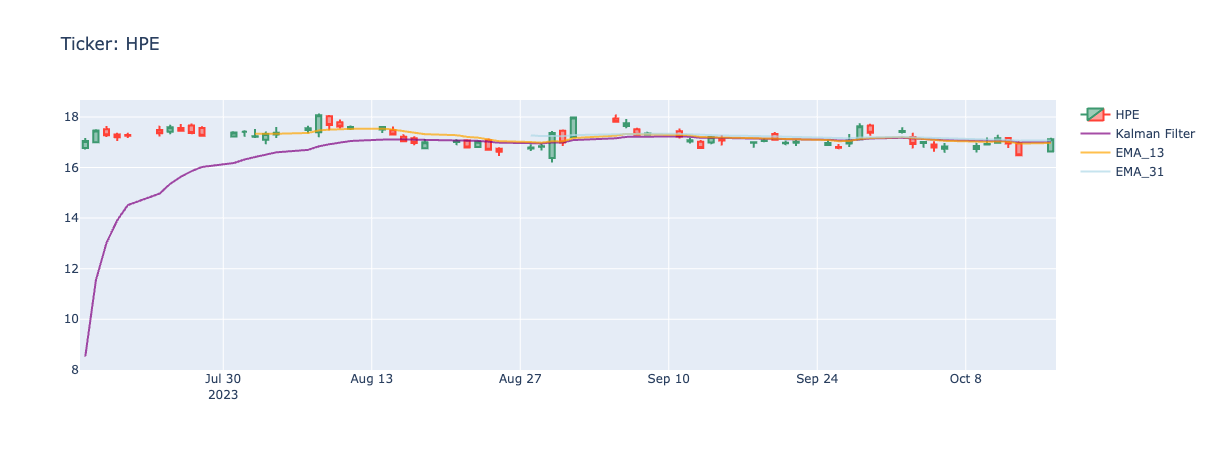

Ticker: RNG

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 30.030000686645508

Ichimoku 9-Day Forecast: 29.675000190734863

Ichimoku 26-Day Forecast: 33.6850004196167

Choppiness (%): 64.63

RSI: 50.611497133451856

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

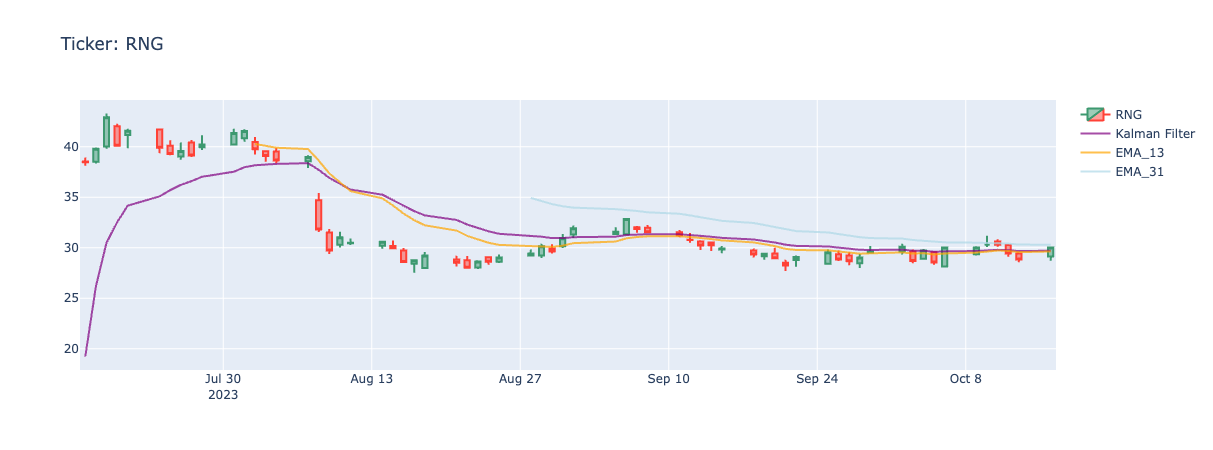

Ticker: RKLB

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 4.474999904632568

Ichimoku 9-Day Forecast: 4.922500014305115

Ichimoku 26-Day Forecast: 5.809999942779541

Choppiness (%): 50.03

RSI: 41.46812099319825

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

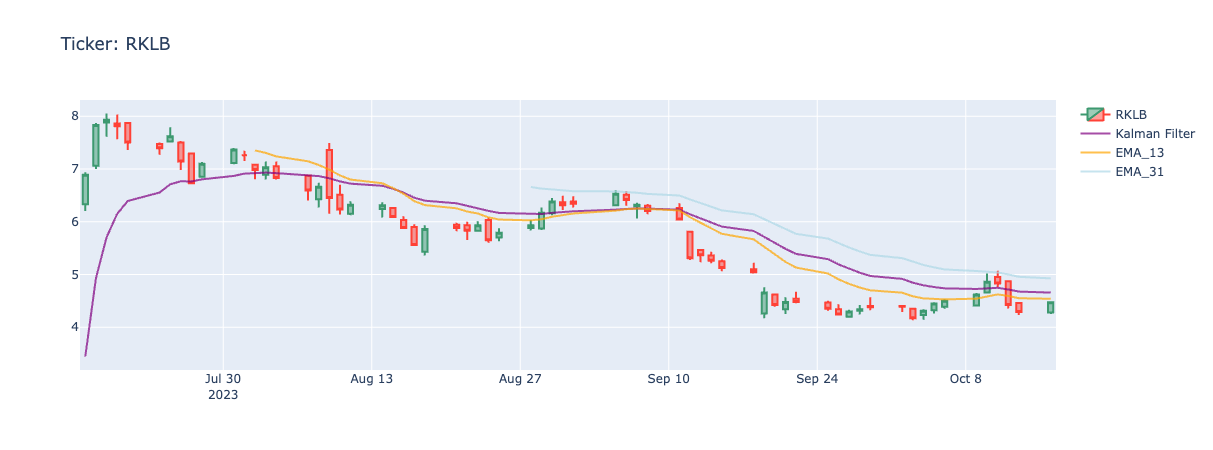

Ticker: LYFT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 10.569999694824219

Ichimoku 9-Day Forecast: 10.757500171661377

Ichimoku 26-Day Forecast: 11.112500190734863

Choppiness (%): 55.47

RSI: 48.29197037886424

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

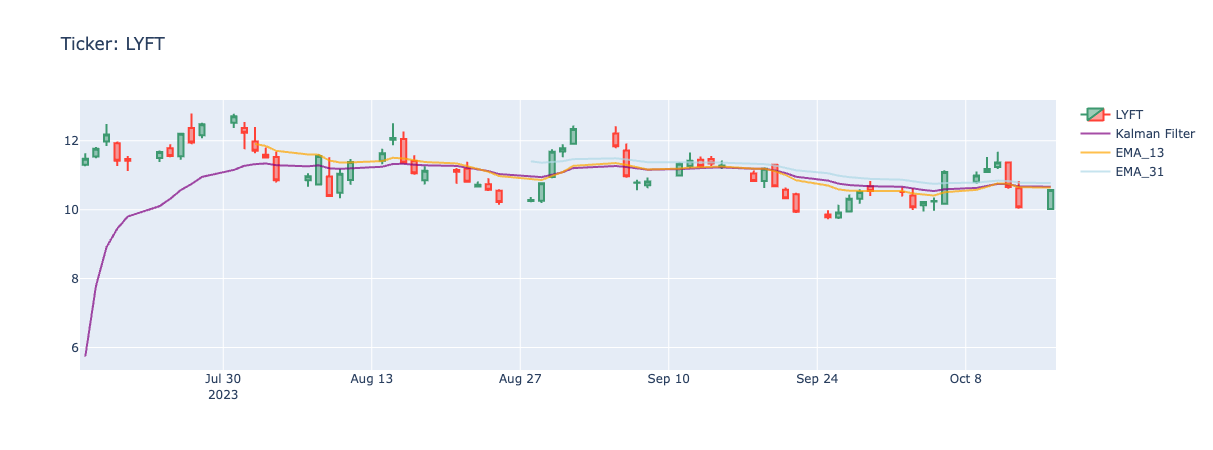

Ticker: FROG

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 24.299999237060547

Ichimoku 9-Day Forecast: 24.946249961853027

Ichimoku 26-Day Forecast: 26.97499942779541

Choppiness (%): 59.13

RSI: 41.8904150739482

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

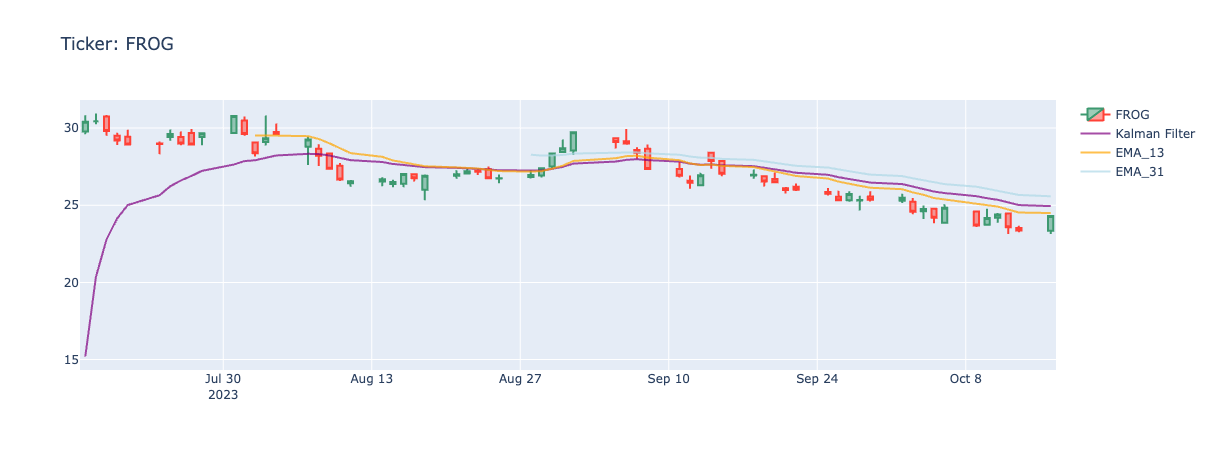

Ticker: DNUT

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 12.199999809265137

Ichimoku 9-Day Forecast: 12.337499856948853

Ichimoku 26-Day Forecast: 13.34499979019165

Choppiness (%): 52.92

RSI: 41.08768801515845

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

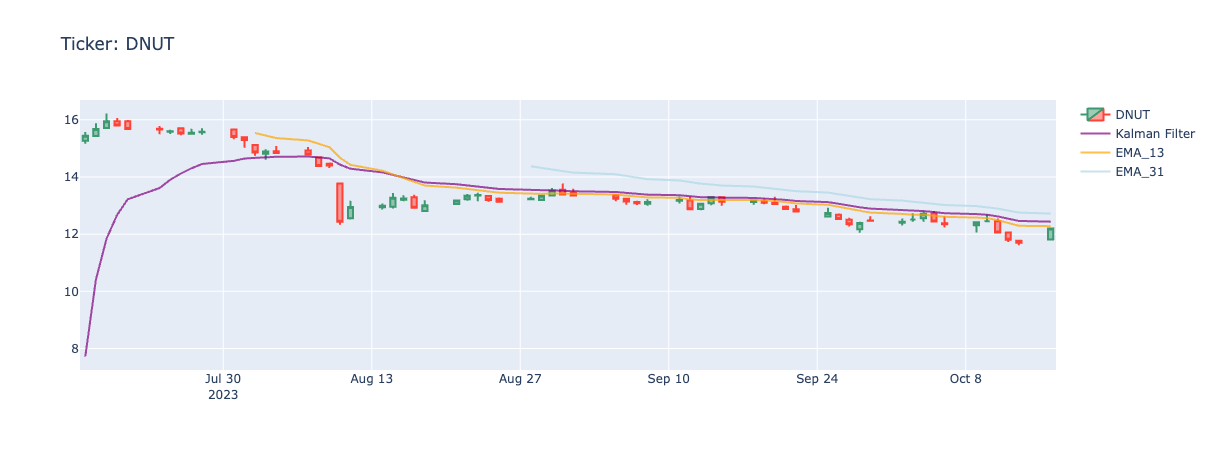

Ticker: KD

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 15.364999771118164

Ichimoku 9-Day Forecast: 15.618499994277954

Ichimoku 26-Day Forecast: 14.619500160217285

Choppiness (%): 62.61

RSI: 49.56919182890958

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

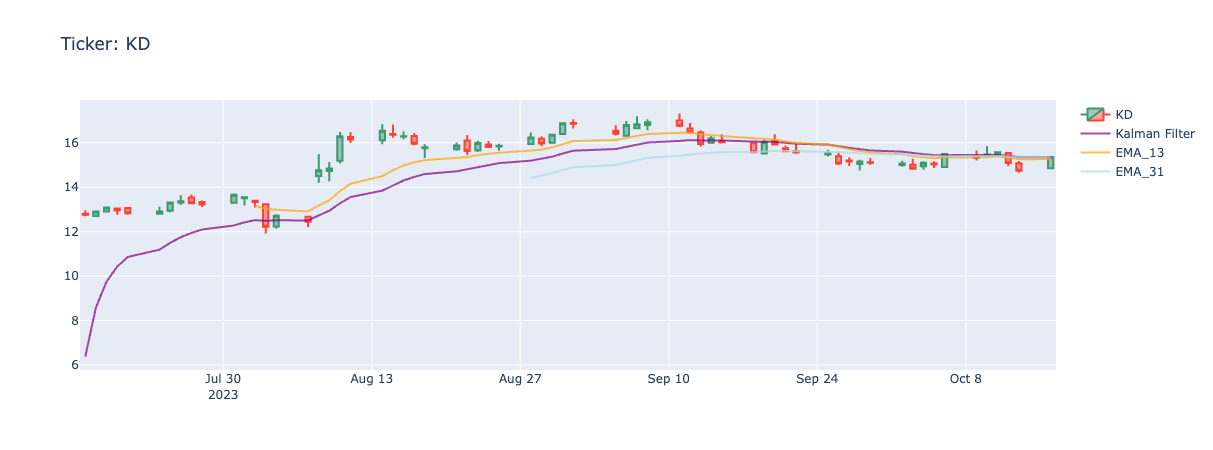

Ticker: SEAS

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 42.4900016784668

Ichimoku 9-Day Forecast: 45.2425012588501

Ichimoku 26-Day Forecast: 49.0

Choppiness (%): 60.10

RSI: 32.446988022488625

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

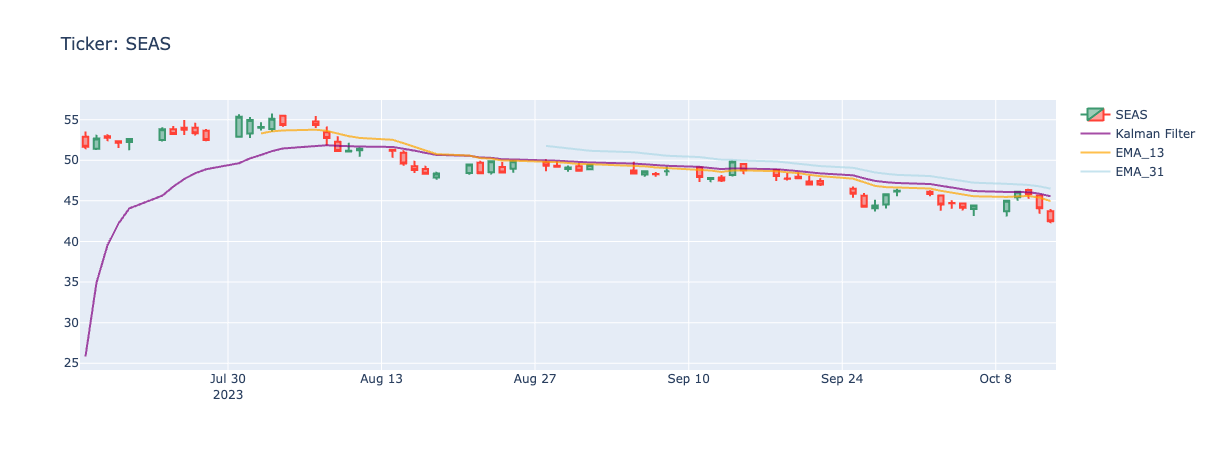

Ticker: MBLY

 "Entry Point"  AMAT &  (EMA_13 > Kalman): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 35.900001525878906

Ichimoku 9-Day Forecast: 37.69999980926514

Ichimoku 26-Day Forecast: 37.864999771118164

Choppiness (%): 43.67

RSI: 40.074336428602116

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

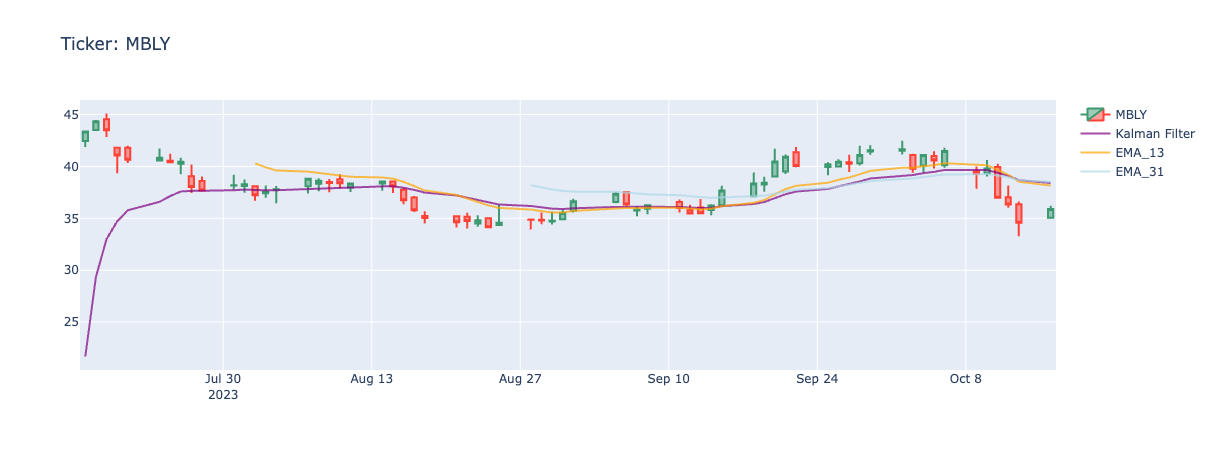

In [25]:
print('\n Exit Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if calculate_symbol(v)[9] == True:
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

In [27]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [ ]:
# Archer Moving Averages Trends
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb
# https://www.tradingview.com/script/Z2mq63fE-Trade-Archer-Moving-Averages-v1-4F/

In [ ]:
# en fin